# **PROBLEM STATEMENT**


**Engage2Value: From Clicks to Conversions**

The task is to predict a customer’s purchase value using anonymized multi-session digital interaction data, including device, traffic source, browser, and geographic features. Modeling user behavior across sessions enables estimation of purchase potential to support data-driven marketing and engagement strategies.


# **IMPORT FREQUENTLY USED LIBRARIES**

In [ ]:

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# **LOADING DATA**

In [2]:
train_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv") 
test_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv") 

# **BASIC INSPECTION**

In [3]:
train_df.head()

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,66,not available in demo dataset,1475804633,Americas,False,1.0


In [4]:
train_df.shape, test_df.shape

((116023, 52), (29006, 51))

# **EXPLORATORY DATA ANALYSIS (EDA)**


EDA is performed to understand the structure and characteristics of the dataset. Key steps include:

- Review dataset structure and feature types  
- Analyze summary statistics and missing values  
- Visualize distributions and relationships 
- Identifying missing values and outliers  
- Exploring categorical and time-based patterns  

**Outcome:** Insights from EDA guide feature engineering and model selection.


In [8]:
from scipy.stats import entropy, median_abs_deviation
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

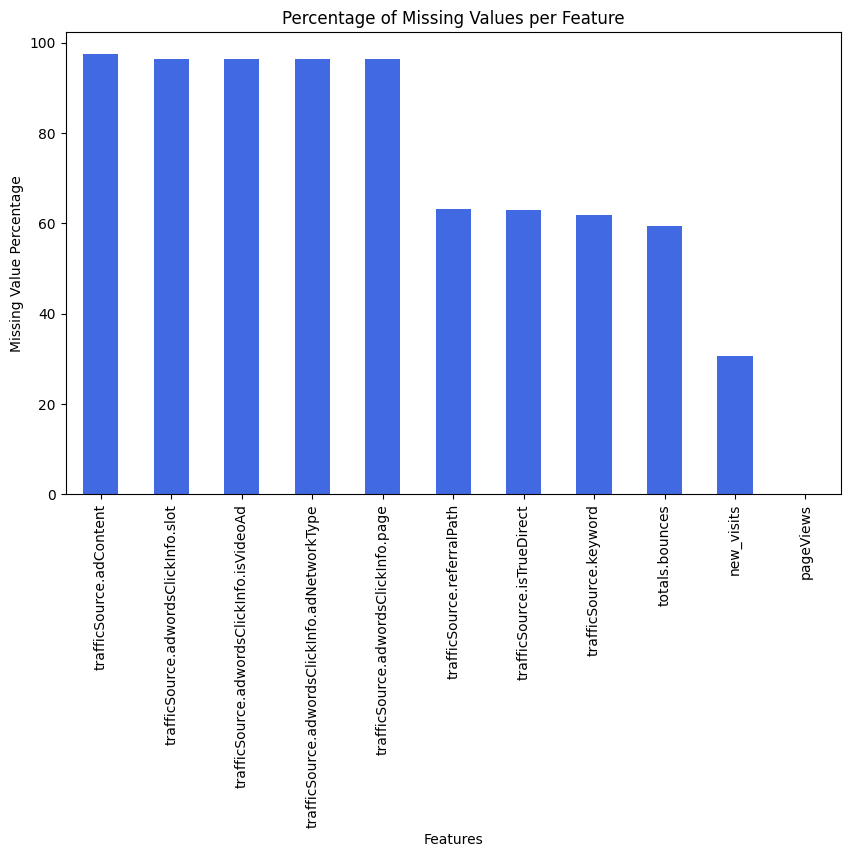

In [9]:
missing_percentage = (train_df.isnull().sum() / len(train_df)) * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar', color='royalblue')
plt.title('Percentage of Missing Values per Feature')
plt.xlabel('Features')
plt.ylabel('Missing Value Percentage')
plt.show()

**Interpretation**

-  Several features exhibit very high missingness (>90%), particularly ad-related variables, and are likely to add noise if retained.
These features likely provide little value for general modeling.

- Features with moderate missing values (≈20–65%) may be considered for imputation based on their importance and distribution.

**Extracting date and time components from sessionStart and date**

In [10]:
def extract_datetime_features(df):
    df = df.copy()
    df['sessionStart'] = pd.to_datetime(df['sessionStart'], unit='s')
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

    df['hour'] = df['sessionStart'].dt.hour
    df['day'] = df['sessionStart'].dt.day
    df['day_of_week'] = df['sessionStart'].dt.dayofweek
    df['month'] = df['sessionStart'].dt.month

    df['date_day'] = df['date'].dt.day
    df['date_month'] = df['date'].dt.month
    df['date_dayofweek'] = df['date'].dt.dayofweek
    df['date_week'] = df['date'].dt.isocalendar().week

    df = df.drop(columns=['sessionStart'])
    return df


In [11]:
train_df = extract_datetime_features(train_df)

In [12]:
train_df.head()

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.isMobile,new_visits,hour,day,day_of_week,month,date_day,date_month,date_dayofweek,date_week
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,False,1.0,6,15,5,7,14,7,4,28
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,False,1.0,6,20,5,5,19,5,4,20
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,False,NaN,14,20,4,10,20,10,4,42
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,False,1.0,8,3,1,1,3,1,1,1
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,False,1.0,1,7,4,10,6,10,3,40


## Summary Statistics

Compact and informative table that summarizes each column with:

| Column                        | Description                               |
| ----------------------------- | ----------------------------------------- |
| `Column`                      | Name of the column                        |
| `Data Type`                   | Dtype (`int64`, `object`, etc.)           |
| `Unique Values (incl. NaN)`   | Count of unique values, including NaNs    |
| `Top 10 Values (with counts)` | Most frequent 10 values (value and count) |
| `% Missing`                   | Percentage of missing values              |
| `Is Constant?`                | True if all non-null values are the same  |
| `Entropy`                     | Measure of randomness / variability       |


In [13]:
# Measure of randomness / variability
def column_entropy(series):
    counts = series.value_counts(normalize=True, dropna=False)
    return entropy(counts)

summary = []

for col in train_df.columns:
    col_data = train_df[col]
    col_dtype = col_data.dtype
    unique_count = col_data.nunique(dropna=False)
    top_values = col_data.value_counts(dropna=False).head(10)
    top_values_str = ', '.join([f"{repr(idx)} ({cnt})" for idx, cnt in top_values.items()])
    pct_missing = col_data.isna().mean() * 100
    is_constant = col_data.nunique(dropna=True) == 1
    col_entropy = column_entropy(col_data)
    
    summary.append({
        'Column': col,
        'Data Type': col_dtype,
        'Unique Values (incl. NaN)': unique_count,
        'Top 10 Values (with counts)': top_values_str,
        '% Missing': round(pct_missing, 2),
        'Is Constant?': is_constant,
        'Entropy': round(col_entropy, 3)
    })

summary_df = pd.DataFrame(summary)

# Display nicely
pd.set_option('display.max_colwidth', 200)
display(summary_df.sort_values('% Missing', ascending=False)) 

,Column,Data Type,Unique Values (incl. NaN),Top 10 Values (with counts),% Missing,Is Constant?,Entropy
4,trafficSource.adContent,object,54,"nan (113060), 'Google Merchandise Store' (1410), 'Google Merchandise Collection' (651), 'Display Ad created 3/11/14' (135), 'Placement Accessores 300 x 250' (114), 'Google Online Store' (104), 'Sm...",97.45,False,0.169
31,trafficSource.adwordsClickInfo.adNetworkType,object,3,"nan (111742), 'Google Search' (2784), 'Content' (1497)",96.31,False,0.182
8,trafficSource.adwordsClickInfo.slot,object,4,"nan (111742), 'Top' (2721), 'RHS' (1557), 'Google Display Network' (3)",96.31,False,0.182
34,trafficSource.adwordsClickInfo.page,float64,6,"nan (111742), 1.0 (4216), 2.0 (50), 3.0 (12), 4.0 (2), 5.0 (1)",96.31,False,0.161
27,trafficSource.adwordsClickInfo.isVideoAd,object,2,"nan (111742), False (4281)",96.31,True,0.158
39,trafficSource.referralPath,object,942,"nan (73309), '/' (17970), '/yt/about/' (5212), '/analytics/web/' (1633), '/yt/about/tr/' (1054), '/yt/about/vi/' (970), '/yt/about/es-419/' (885), '/yt/about/pt-BR/' (827), '/yt/about/th/' (800), ...",63.18,False,1.800
0,trafficSource.isTrueDirect,object,2,"nan (73133), True (42890)",63.03,True,0.659
5,trafficSource.keyword,object,567,"nan (71861), '(not provided)' (39066), '6qEhsCssdK0z36ri' (1155), '(User vertical targeting)' (924), '(automatic matching)' (670), '(Remarketing/Content targeting)' (316), 'google merchandise stor...",61.94,False,0.942
40,totals.bounces,float64,2,"nan (68875), 1.0 (47148)",59.36,True,0.676
50,new_visits,float64,2,"1.0 (80518), nan (35505)",30.60,True,0.616


* **What to learn from the table**

    - **High missing %:** Consider dropping or imputing.  
    - **Constant / low variance:** Drop — no predictive power.  
    - **Low entropy:** Likely uninformative.  
    - **Suspicious top values:** Check for placeholders or incorrect types. 


* **Columns to Drop**

    **1. Low Variance / Constant Features**  
    ~15 columns (e.g., `device.screenResolution`, `totals.visits`, `browserMajor`) have a single unique value and provide no predictive signal.

    **2. High Missingness (>90%)**  
    5 features (e.g., `trafficSource.adContent`, `trafficSource.adwordsClickInfo.slot`, etc.) have excessive missing values and can be dropped unless critical.


## Correlation Analysis of numerical values

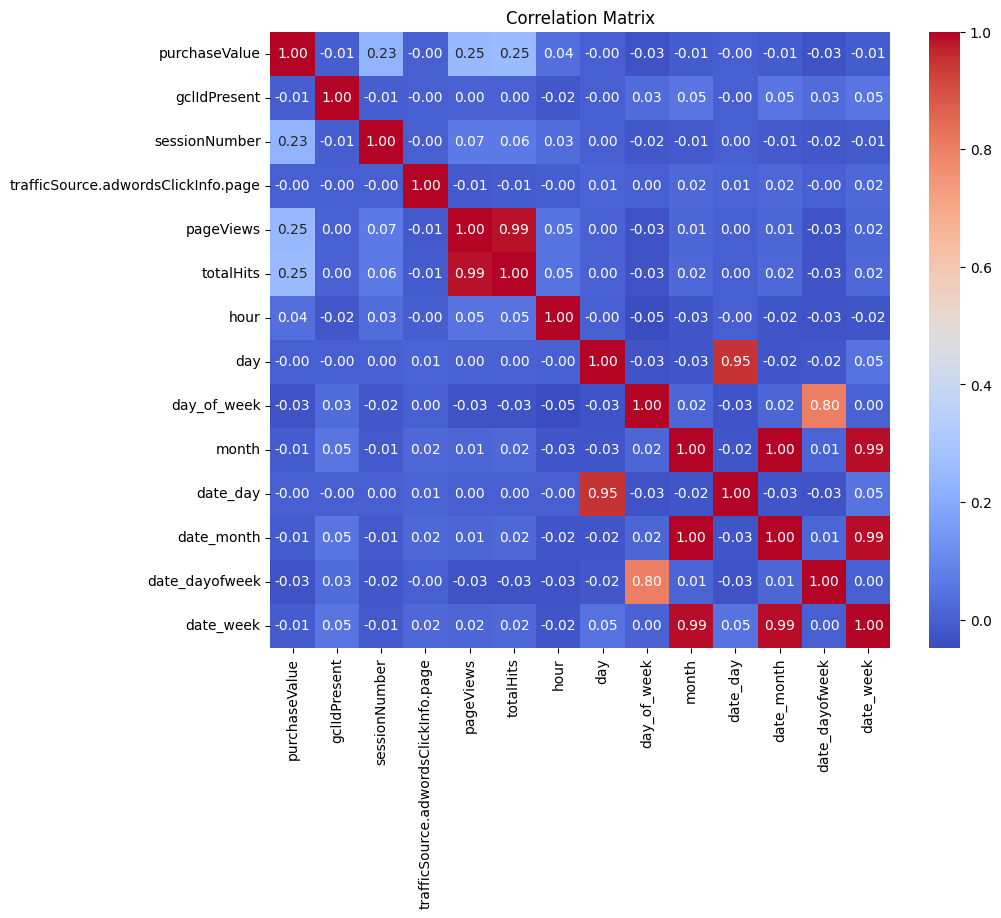

In [14]:
numeric_df = train_df.select_dtypes(include=['number'])
numeric_df = numeric_df.fillna(numeric_df.mean())
numeric_df = numeric_df.loc[:, numeric_df.nunique() > 1]
numeric_df = numeric_df.drop(columns=['userId','sessionId'], axis=1)

corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Correlation Matrix Interpretation**

**1. Key Features Correlated with `purchaseValue`**  
- `totalHits` (0.25), `pageViews` (0.24), `sessionNumber` (0.23) – moderate positive correlation; good predictors.  
- `hour` (0.04), `gclIdPresent` (-0.01), other date/time features (~0) – weak or no linear correlation.

**2. Features with Little to No Correlation**  
- `gclIdPresent`, some ad-related fields, all date-related features – not informative linearly, may still help non-linear models.

**3. Highly Correlated Features (Multicollinearity)**  
- `pageViews` vs `totalHits` (0.99) – almost identical; keep one.  
- Temporal features (`month`, `date_month`, `day`, `date_day`, `day_of_week`) – highly redundant; drop duplicates to reduce multicollinearity.


## **Multicollinearity Check**

In [15]:

excluded_columns = ['userId', 'sessionId']
numeric_df = train_df.select_dtypes(include='number').drop(columns=excluded_columns, errors='ignore')

numeric_df = numeric_df.loc[:, numeric_df.apply(pd.Series.nunique) > 1]

numeric_df = numeric_df.dropna()
X = numeric_df.astype('float64')
X = add_constant(X)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)


                                Feature         VIF
11                           date_month  266.224272
13                            date_week  156.395822
9                                 month  112.426848
1                          gclIdPresent   58.009655
4                             pageViews   48.885645
5                             totalHits   48.882927
10                             date_day   10.357508
7                                   day    9.143686
12                       date_dayofweek    2.411270
8                           day_of_week    2.354296
0                         purchaseValue    1.290779
2                         sessionNumber    1.030443
3   trafficSource.adwordsClickInfo.page    1.022053
6                                  hour    1.007293


**Variance Inflation Factor (VIF) Interpretation**

- **High VIF (>10):** Indicates strong multicollinearity with other features.  
- **Low VIF (<5):** Feature is largely independent.

**Key Observations:**
- Very high multicollinearity: `date_month` (266), `date_week` (156), `month` (112) → redundant time features, keep only one.  
- High correlation: `totalHits` and `pageViews` (~49) → drop one.  
- Moderate/high: `date_day` (10.3), `day` (9.1) → borderline; monitor.  
- Acceptable/low: `date_dayofweek`, `day_of_week` (~2.4), rest < 2 → safe.  

**Takeaway:** Drop or consolidate highly collinear features to reduce redundancy and improve regression stability.


## **Univariate Feature Analysis**

### **Numerical Features**

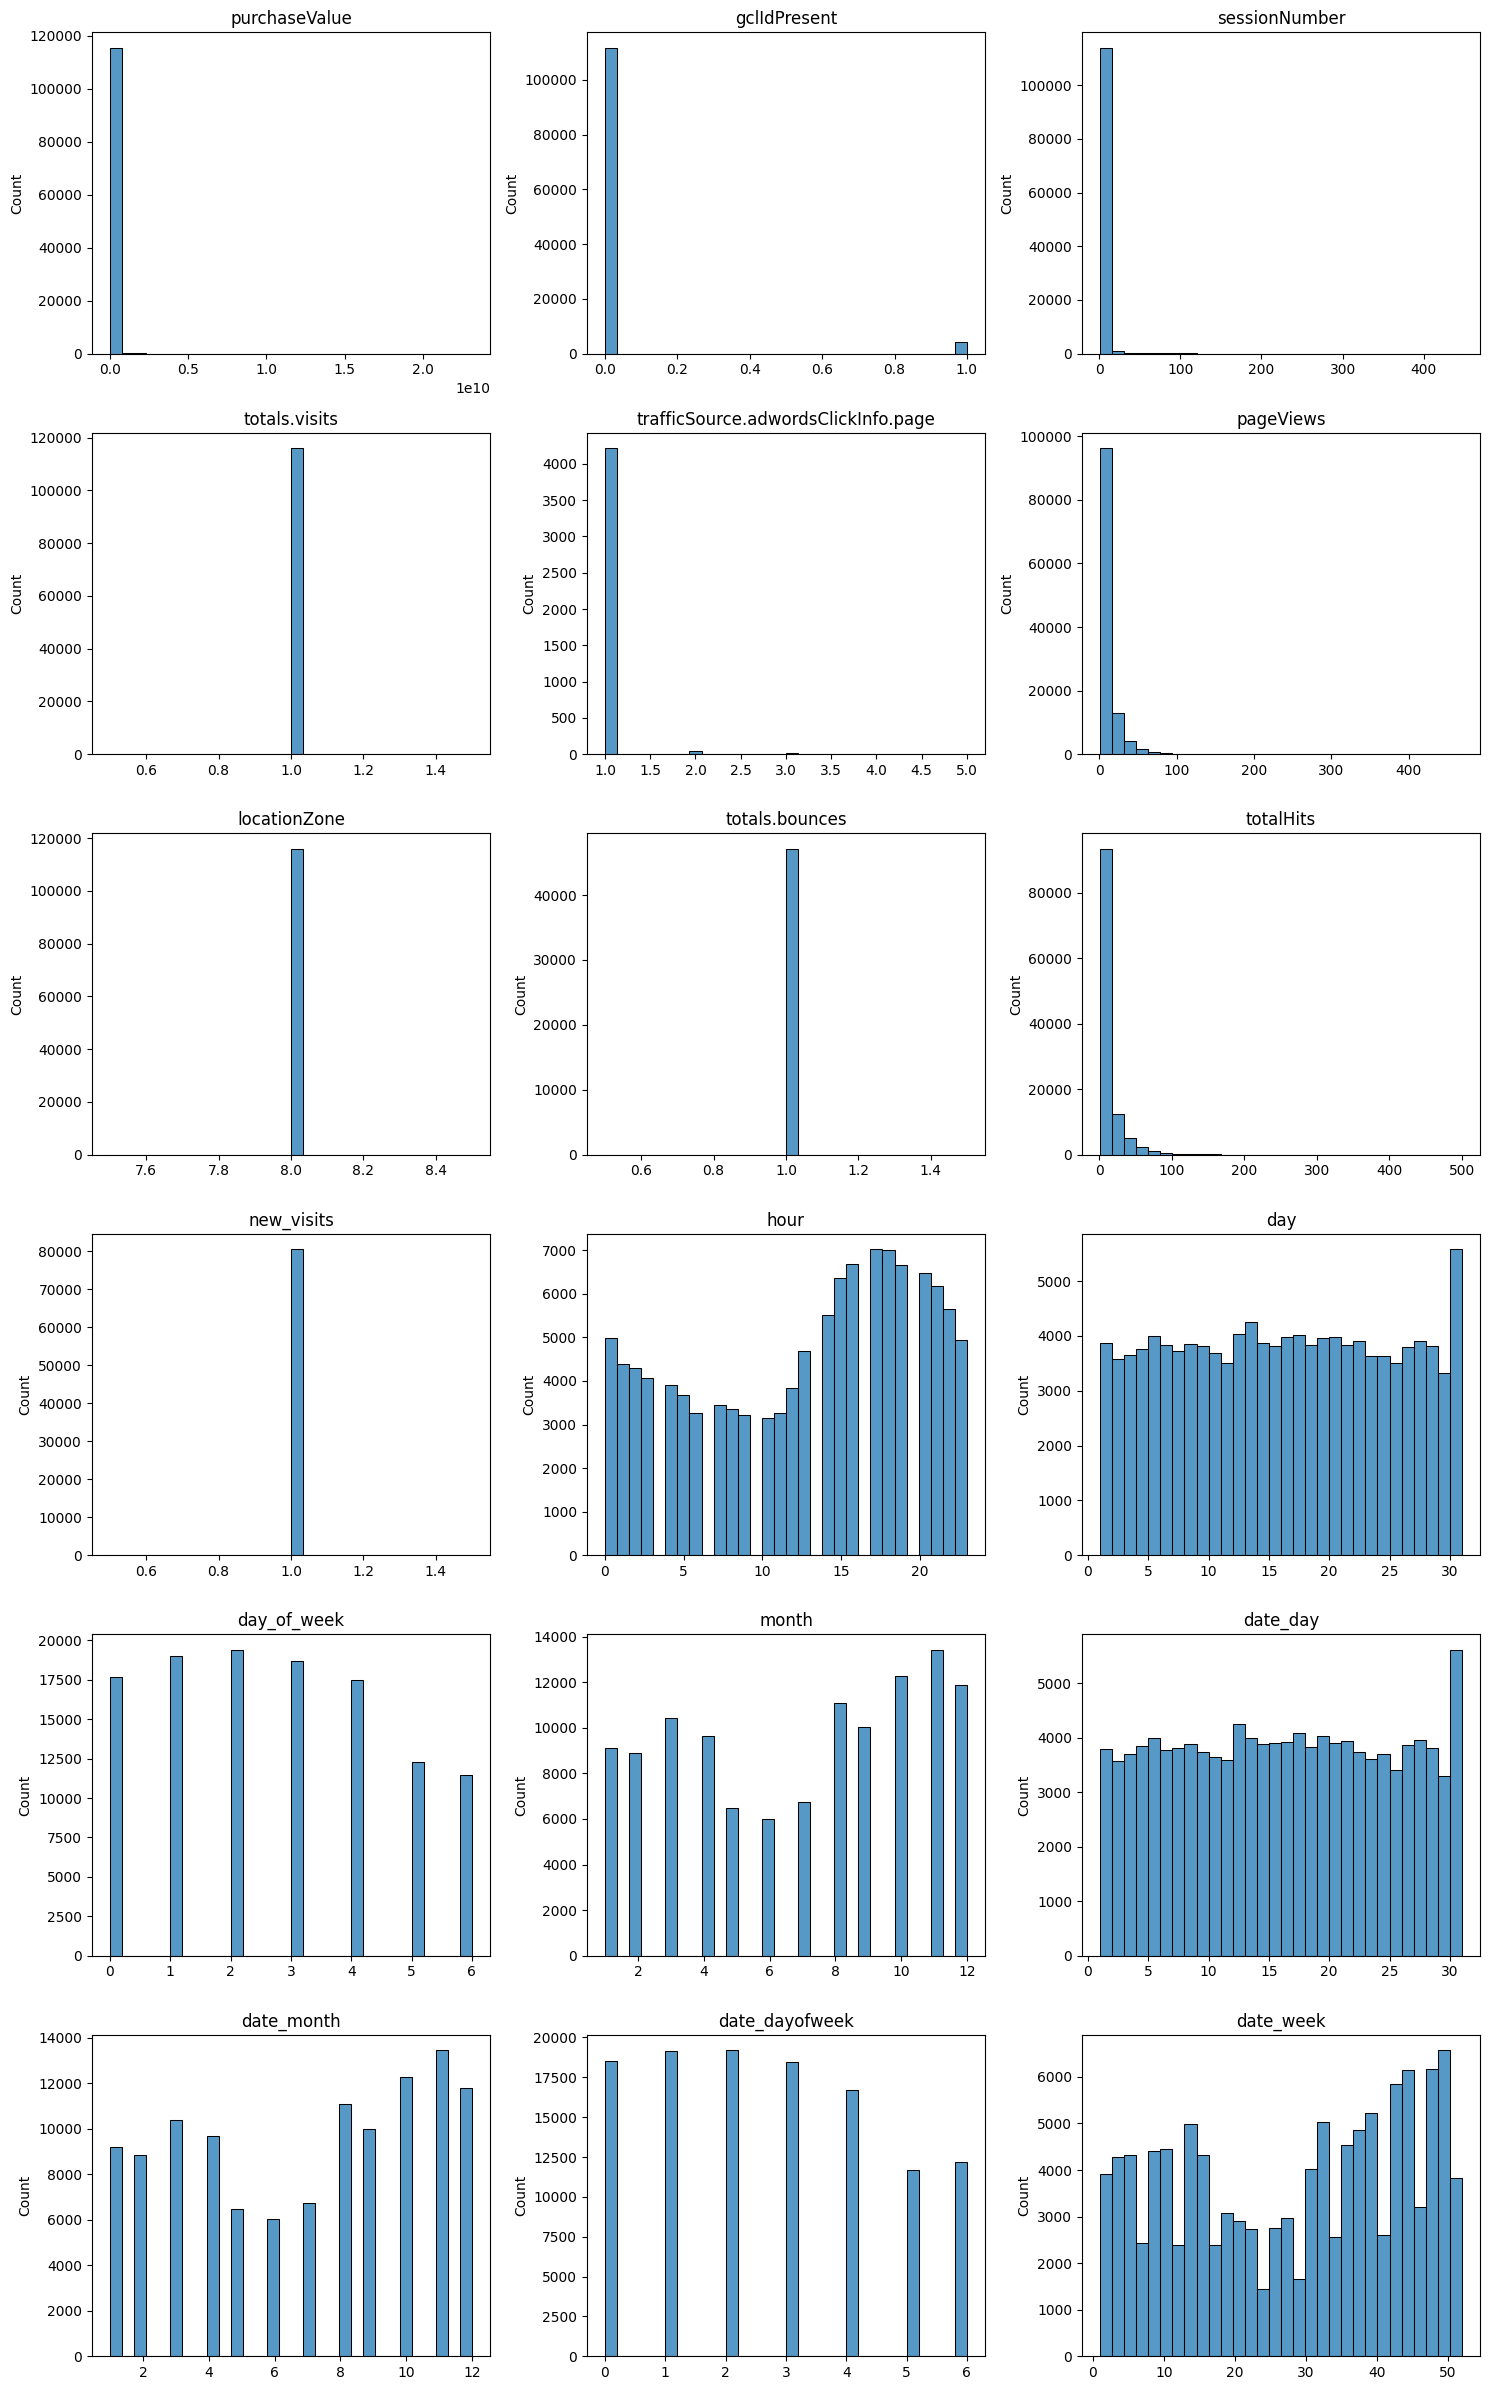

In [16]:

exclude_manual = ['userId', 'sessionId']
numerical_cols = [
    col for col in train_df.select_dtypes(include='number').columns
    if col not in exclude_manual and train_df[col].nunique() < 0.9 * len(train_df)
]

n_cols = 3
n_rows = -(-len(numerical_cols) // n_cols) 

plt.figure(figsize=(n_cols * 5, n_rows * 4))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(train_df[col].dropna(), kde=False, bins=30)
    plt.title(col)
    plt.xlabel('')
plt.tight_layout()
plt.show()

#### **Skewness Analysis**


Top Skewed Features (Uncapped):

purchaseValue                          53.907209
sessionNumber                          20.437272
trafficSource.adwordsClickInfo.page    11.267731
pageViews                               5.777652
totalHits                               5.601207
gclIdPresent                            4.904278
date_dayofweek                          0.209704
day_of_week                             0.183243
date_day                                0.014687
day                                     0.012676
date_week                              -0.180961
month                                  -0.182548
date_month                             -0.182606
hour                                   -0.358655
dtype: float64


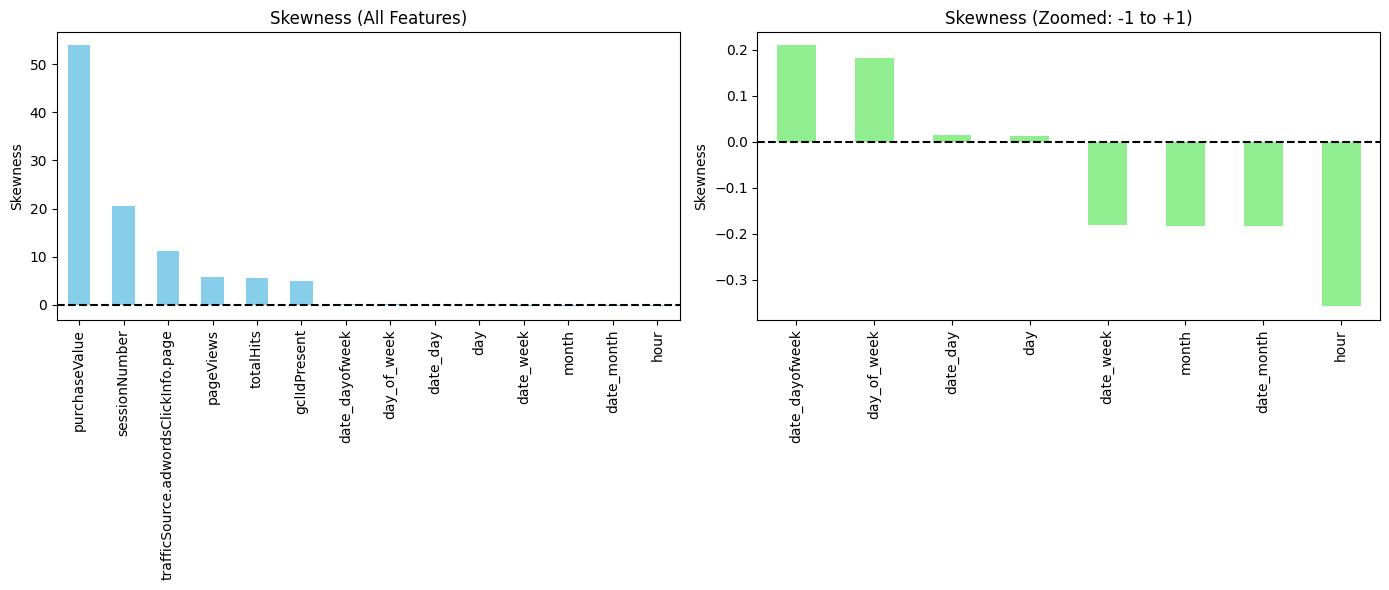

In [17]:
from scipy.stats import skew

exclude_manual = ['userId', 'sessionId']
numeric_cols = [
    col for col in train_df.select_dtypes(include='number').columns
    if col not in exclude_manual and train_df[col].nunique(dropna=True) > 1
]

skewed_features = train_df[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

print("\nTop Skewed Features (Uncapped):\n")
print(skewed_features.sort_values(ascending=False))

# --- Plot 1: All skewness values ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
skewed_features.plot(kind='bar', color='skyblue')
plt.axhline(0, color='black', linestyle='--')
plt.title('Skewness (All Features)')
plt.ylabel('Skewness')

# --- Plot 2: Zoomed in on skewness between -1 and +1 ---
plt.subplot(1, 2, 2)
skewed_zoom = skewed_features[skewed_features.between(-1, 1)]
skewed_zoom.plot(kind='bar', color='lightgreen')
plt.axhline(0, color='black', linestyle='--')
plt.title('Skewness (Zoomed: -1 to +1)')
plt.ylabel('Skewness')

plt.tight_layout()
plt.show()

**Skewness Interpretation**

**Skewness Overview:**  
- ≈ 0 → Symmetric (normal)  
- \> 0 → Right-skewed (long tail to the right)  
- < 0 → Left-skewed (long tail to the left)  

**Observations:**  
- Extremely right-skewed: `purchaseValue` (53.9), `sessionNumber` (20.4)  
- Moderately skewed: `totalHits`, `pageViews` (~5–6), `gclIdPresent` (~4.9)  
- Symmetric: `hour`, `month`, etc. (~0)

**Actionable Steps:**  
- Highly skewed (|skew| > 1) → Apply log transformation or binning to reduce outlier impact.  
- Symmetric (|skew| < 0.5) → No transformation needed.


## **Outlier Detection**

#### **Boxplot For Outlier Detection (IQR)**

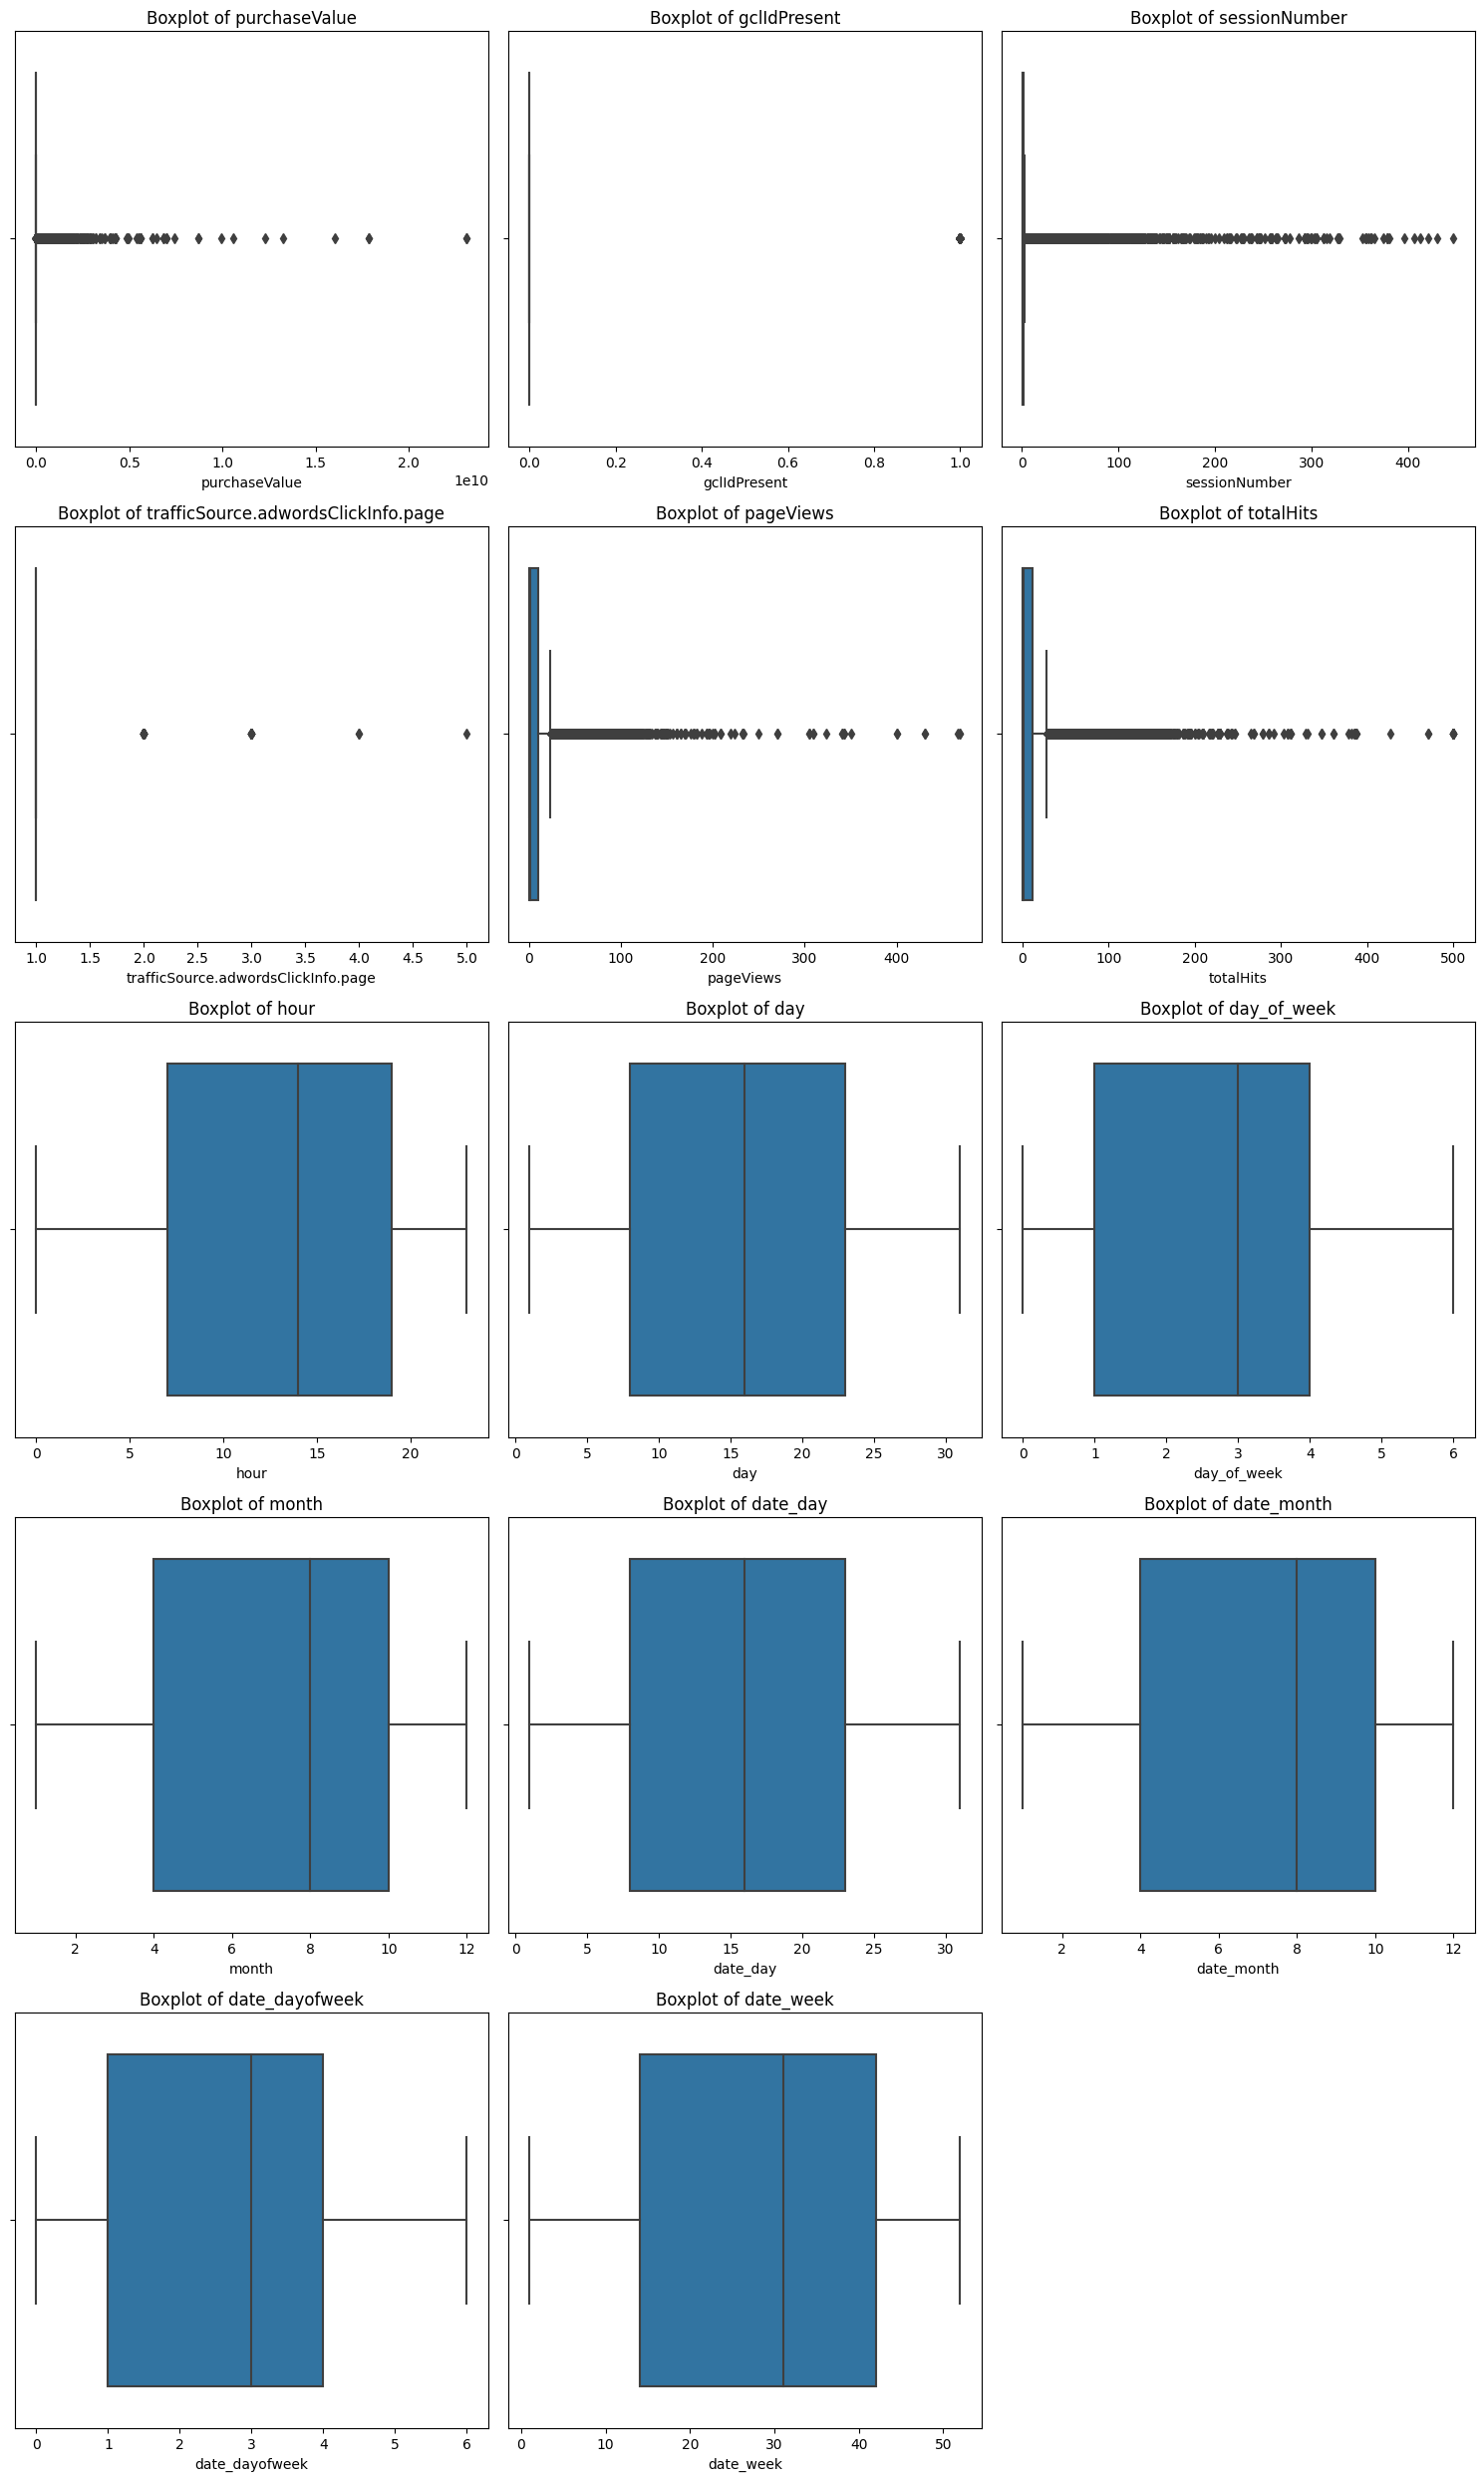

In [19]:
numeric_cols = train_df.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if train_df[col].std() != 0]

numeric_cols = [col for col in numeric_cols if col not in ['userId', 'sessionId']]

n_cols = 3  
n_rows = -(-len(numeric_cols) // n_cols)  


plt.figure(figsize=(n_cols * 5, n_rows * 5))  

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

#### **IQR to detect outliers**

In [20]:
for col in numeric_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
    print(f"Outliers in {col}: {len(outliers)}")

Outliers in purchaseValue: 23985
Outliers in gclIdPresent: 4295
Outliers in sessionNumber: 14116
Outliers in trafficSource.adwordsClickInfo.page: 65
Outliers in pageViews: 12419
Outliers in totalHits: 13154
Outliers in hour: 0
Outliers in day: 0
Outliers in day_of_week: 0
Outliers in month: 0
Outliers in date_day: 0
Outliers in date_month: 0
Outliers in date_dayofweek: 0
Outliers in date_week: 0


#### **Modified Z-score to detect outliers**

In [21]:

outliers_dict = {}

for col in numeric_cols:
    median = train_df[col].median()
    mad = median_abs_deviation(train_df[col], scale='normal')
    
    # Modified Z-score calculation
    mod_z = 0.6745 * (train_df[col] - median) / mad
    
    # Flag outliers
    outliers = train_df[abs(mod_z) > 3.5]
    outliers_dict[col] = outliers
    print(f"Modified Z-score outliers in {col}: {len(outliers)}")

Modified Z-score outliers in purchaseValue: 23985
Modified Z-score outliers in gclIdPresent: 4295
Modified Z-score outliers in sessionNumber: 35505
Modified Z-score outliers in trafficSource.adwordsClickInfo.page: 0
Modified Z-score outliers in pageViews: 0
Modified Z-score outliers in totalHits: 32766
Modified Z-score outliers in hour: 0
Modified Z-score outliers in day: 0
Modified Z-score outliers in day_of_week: 0
Modified Z-score outliers in month: 0
Modified Z-score outliers in date_day: 0
Modified Z-score outliers in date_month: 0
Modified Z-score outliers in date_dayofweek: 0
Modified Z-score outliers in date_week: 0


#### **Isolation Forest**

In [22]:
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer

train_df_copy = train_df.copy()
X = train_df_copy[numeric_cols]
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Initialize Isolation Forest with contamination = 1% 
model = IsolationForest(contamination=0.01, random_state=42)
train_df_copy['outlier'] = model.fit_predict(X_imputed)

# -1 = outlier, 1 = inlier
outliers_if = train_df_copy[train_df_copy['outlier'] == -1]
print(f"Outliers detected by Isolation Forest: {len(outliers_if)}")

Outliers detected by Isolation Forest: 1161


### Outlier Analysis

| Feature                           | IQR Outliers | Modified Z Outliers | Isolation Forest Outliers |
| --------------------------------- | ------------ | ----------------- | ------------------------ |
| `purchaseValue`                   | 23,985       | 23,985            | ✓ included in 1,161      |
| `gclIdPresent`                    | 4,295        | 4,295             | ✓                        |
| `sessionNumber`                   | 14,116       | 35,505            | ✓                        |
| `pageViews`                       | 12,419       | 0                 | ✓                        |
| `totalHits`                       | 13,154       | 32,766            | ✓                        |
| `adwordsClickInfo.page`           | 65           | 0                 | ✓                        |
| All `date_` and time-related cols | 0            | 0                 | ✗ not outliers           |
| **Isolation Forest (total)**      | —            | —                 | **1,161 total**           |

**Interpretation:**  
- **IQR & Modified Z-score:** Detect univariate extremes; differences reflect skewed or non-normal distributions.  
- **Isolation Forest:** Detects 1,161 true multivariate outliers; focuses on unusual combinations rather than single extreme values.  


## **Target Variable Analysis (purchaseValue)**

Text(0.5, 1.0, 'Purchase Value Distribution')

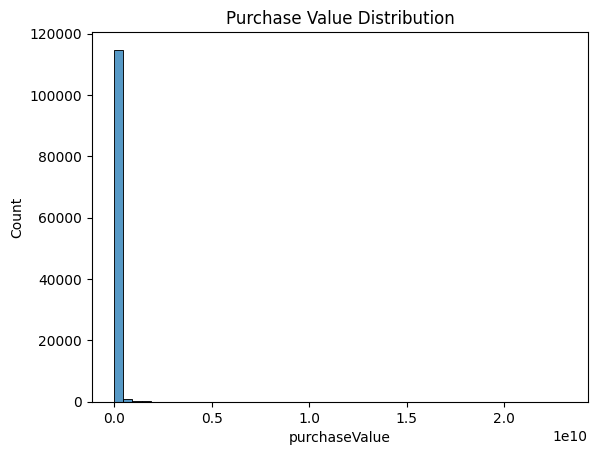

In [23]:
sns.histplot(train_df['purchaseValue'], bins=50)
plt.title("Purchase Value Distribution")




From the above histogram of purchaseValue (target) we can observe:


- ~79% of sessions have `purchaseValue = 0.0`, creating a dominant spike.  
- Paying users are rare, with a long-tailed distribution.  
- Imbalanced and skewed target makes analysis and modeling challenging.

**Conclusion:** Consider applying data transformation to handle skewness.

### **Bivariate analysis (Target vs Features)**

#### **Target vs Numerical Features**

Top Correlated Numeric Features with purchaseValue:
totalHits        0.251651
pageViews        0.248454
sessionNumber    0.230585
Name: purchaseValue, dtype: float64


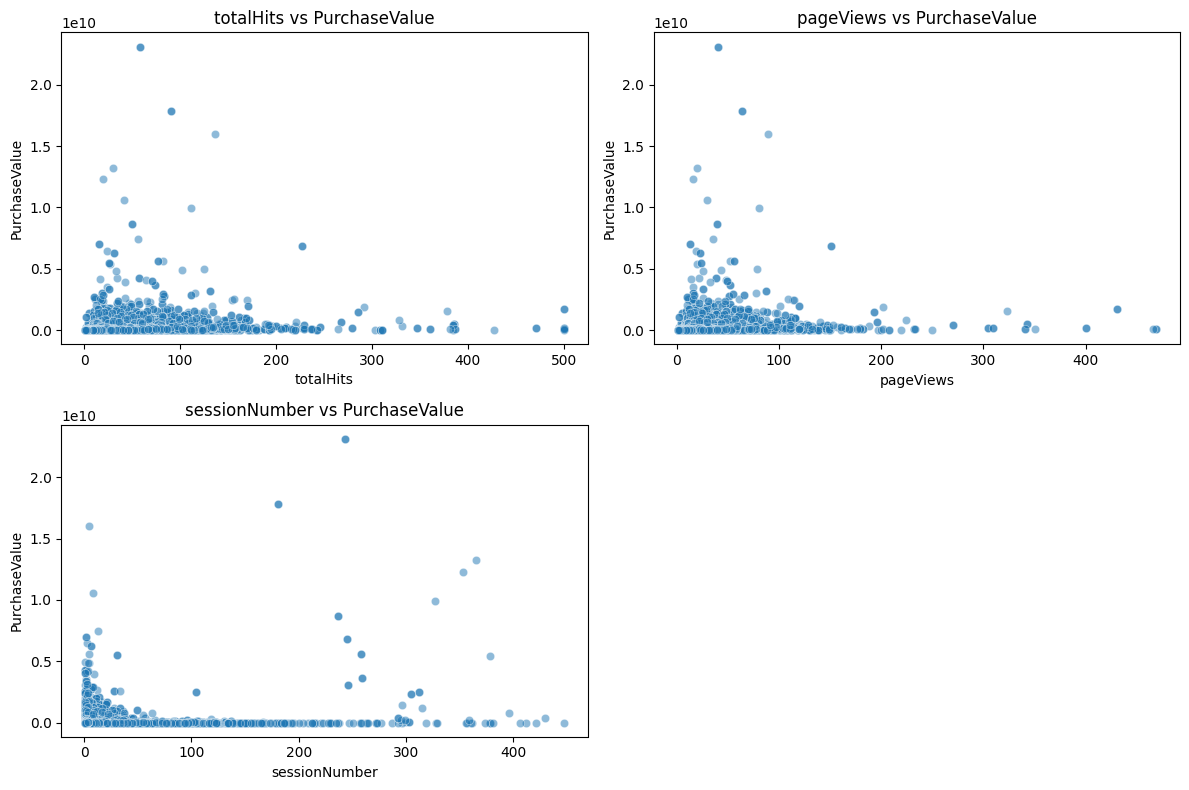

In [24]:
numeric_cols = train_df.select_dtypes(include='number').columns.tolist()

exclude_cols = ['userId', 'sessionId']  
numeric_cols = [col for col in numeric_cols if col not in exclude_cols and col != 'purchaseValue']

# Correlation with the target
correlations = train_df[numeric_cols + ['purchaseValue']].corr()['purchaseValue'].drop('purchaseValue')

# Filter features with meaningful correlation
selected_features = correlations[correlations.abs() > 0.1].sort_values(ascending=False)

print("Top Correlated Numeric Features with purchaseValue:")
print(selected_features)

n_cols = 2
n_rows = -(-len(selected_features) // n_cols)

plt.figure(figsize=(n_cols * 6, n_rows * 4))
for i, col in enumerate(selected_features.index, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=train_df[col], y=train_df['purchaseValue'], alpha=0.5)
    plt.title(f"{col} vs PurchaseValue")
    plt.xlabel(col)
    plt.ylabel("PurchaseValue")
plt.tight_layout()
plt.show()


#### **Target vs Categorical Features**

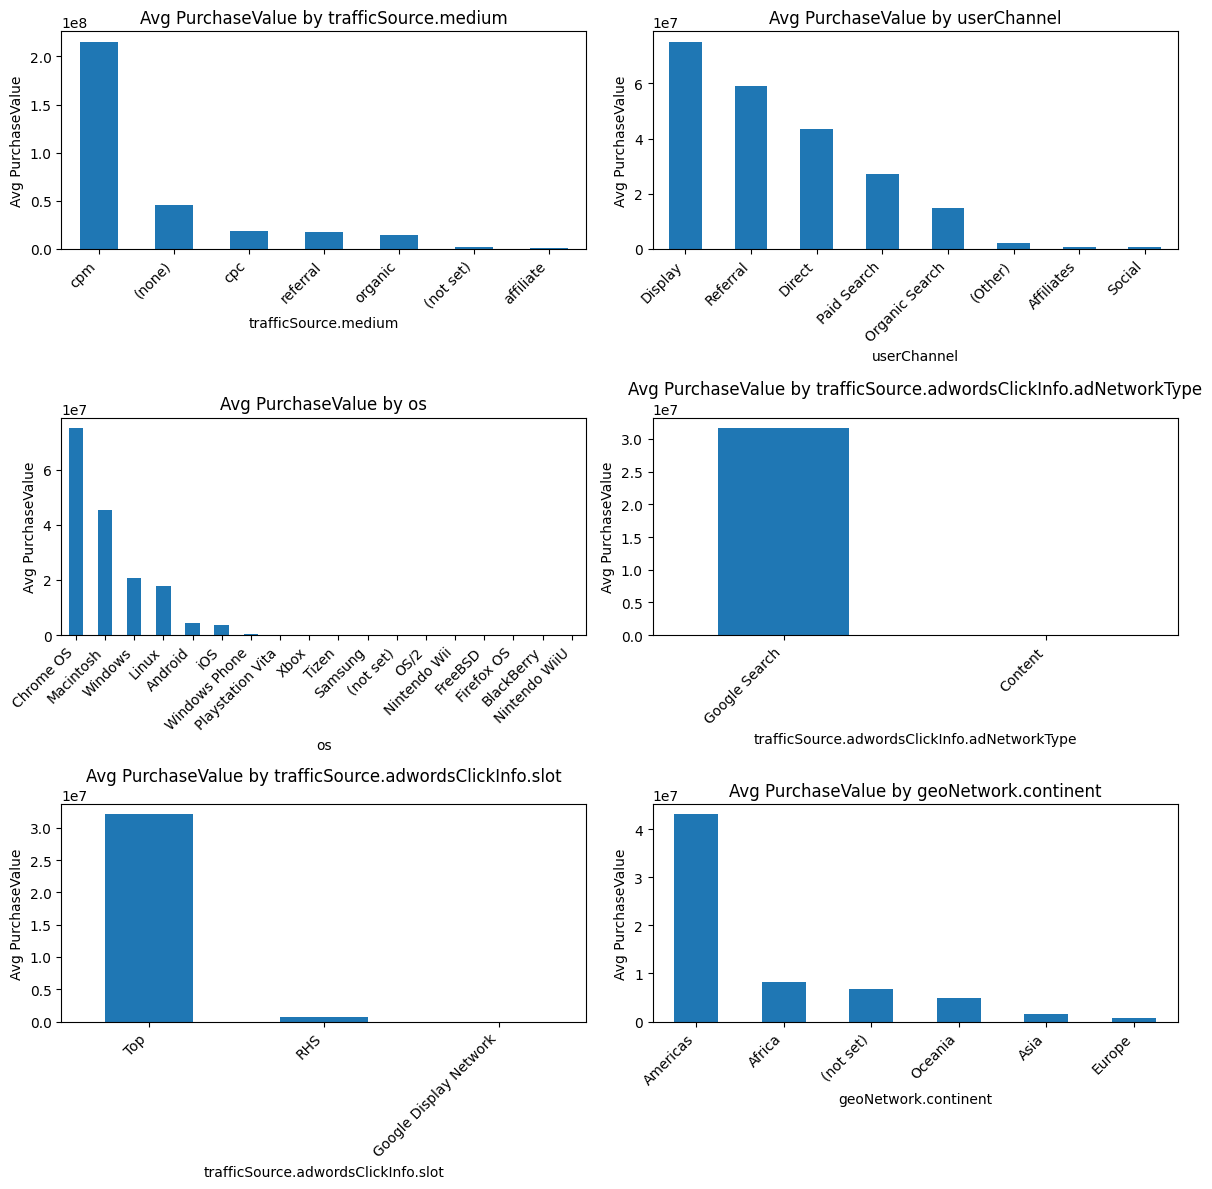

In [25]:
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

cat_cols_nonconstant = [col for col in categorical_cols if train_df[col].nunique(dropna=True) > 1]

cat_cols_low_card = [col for col in cat_cols_nonconstant if train_df[col].nunique() <= 30]

category_target_stats = {}
for col in cat_cols_low_card:
    means = train_df.groupby(col)['purchaseValue'].mean().sort_values(ascending=False)
    category_target_stats[col] = means

cat_feature_variances = {
    col: np.var(train_df.groupby(col)['purchaseValue'].mean()) 
    for col in cat_cols_low_card
}

sorted_cat_features = sorted(cat_feature_variances.items(), key=lambda x: x[1], reverse=True)

top_categorical_features = [col for col, _ in sorted_cat_features if _ > 0]

n_cols = 2
n_rows = -(-len(top_categorical_features[:6]) // n_cols)

plt.figure(figsize=(n_cols * 6, n_rows * 4))
for i, col in enumerate(top_categorical_features[:6], 1):
    plt.subplot(n_rows, n_cols, i)
    avg_purchase = train_df.groupby(col)['purchaseValue'].mean().sort_values(ascending=False)
    avg_purchase.plot(kind='bar')
    plt.title(f'Avg PurchaseValue by {col}')
    plt.ylabel('Avg PurchaseValue')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



## **Time Based EDA**

### **Trend Over Calendar Time**

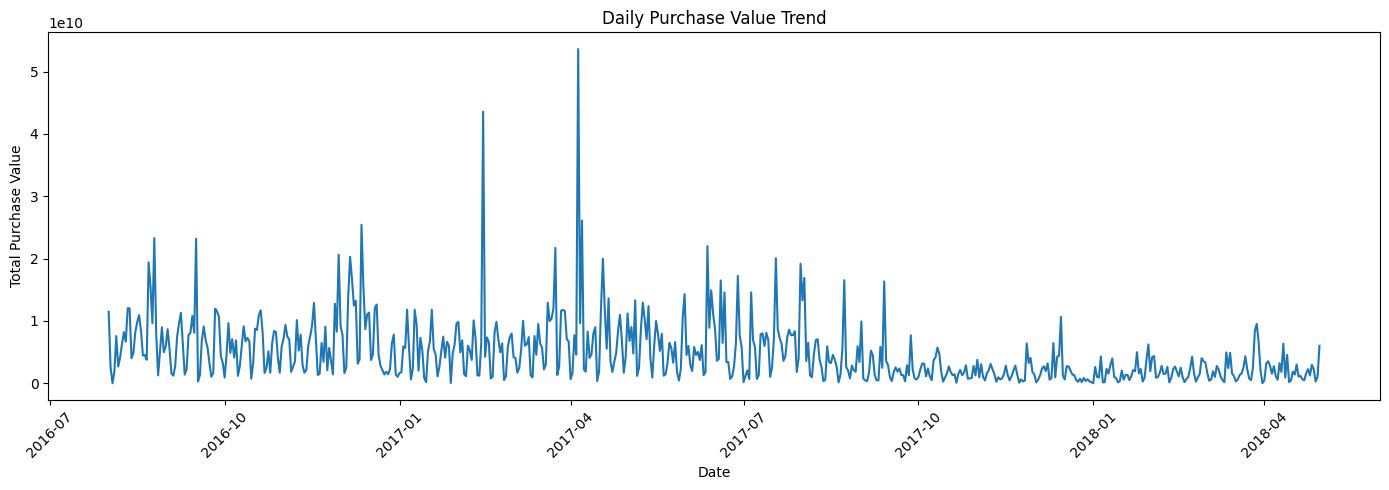

In [26]:

original_df['date'] = pd.to_datetime(original_df['date'], format='%Y%m%d')
daily_trend = original_df.groupby('date')['purchaseValue'].sum().reset_index()

plt.figure(figsize=(14, 5))
sns.lineplot(data=daily_trend, x='date', y='purchaseValue')
plt.title('Daily Purchase Value Trend')
plt.xlabel('Date')
plt.ylabel('Total Purchase Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Trend Over Calendar Time – Insights & Interpretation**
 
- **Peak Periods:** Feb 2017 and Apr 2017 likely driven by promotions or seasonal events.  
- **Decline After Oct 2017:** Purchase activity drops sharply and remains low.  
- **Stable Activity Before Oct 2017:** Consistent purchases indicate a more active period.



### **Purchases by Day of Week**

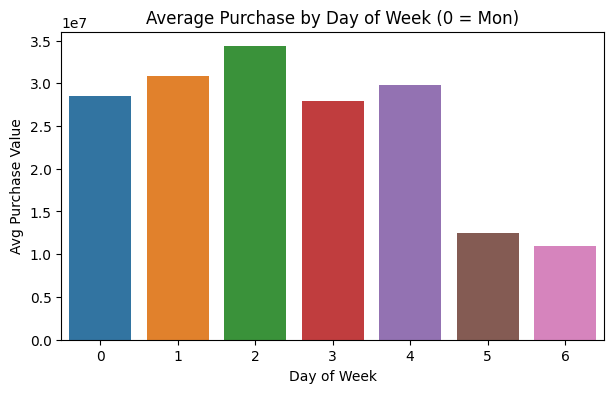

In [27]:
dow = train_df.groupby('day_of_week')['purchaseValue'].mean().reset_index()

plt.figure(figsize=(7, 4))
sns.barplot(x='day_of_week', y='purchaseValue', data=dow)
plt.title('Average Purchase by Day of Week (0 = Mon)')
plt.xlabel('Day of Week')
plt.ylabel('Avg Purchase Value')
plt.show()


**Purchase by Day of Week - Interpretations**

| Day           | Avg Purchase Value |
| ------------- | ---------------- |
| Mon–Fri       | 28–34M           |
| Wednesday     | 34.3M (Highest)  |
| Saturday      | 12.5M            |
| Sunday        | 11.0M (Lowest)   |

**Insights:**  
- Peak midweek activity (Wednesday) suggests higher weekday engagement.  
- Weekdays consistently outperform weekends.  
- Weekends show significantly lower purchase activity.


### **Weekday vs. Weekend Comparison**

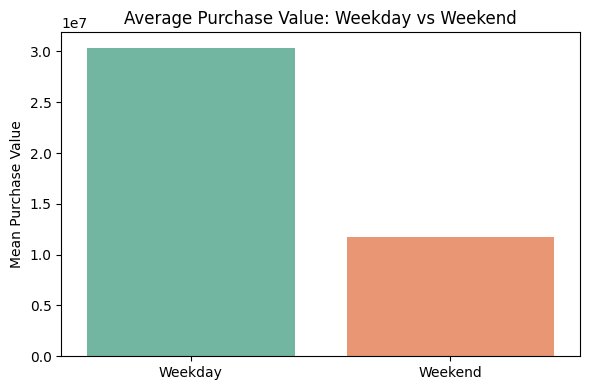

In [28]:
day_type_df = train_df[['day_of_week', 'purchaseValue']].copy()
day_type_df['day_type'] = day_type_df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

comparison = day_type_df.groupby('day_type')['purchaseValue'].agg(['mean', 'median', 'count']).reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=comparison, x='day_type', y='mean', palette='Set2')
plt.title('Average Purchase Value: Weekday vs Weekend')
plt.ylabel('Mean Purchase Value')
plt.xlabel('')
plt.tight_layout()
plt.show()


**Weekday vs. Weekend Comparison – Insights & Interpretation**

| Day Type    | Mean Purchase Value | Median Purchase Value | Records  |
| ----------- | ----------------- | ------------------- | -------- |
| Weekday     | 30.4M             | 0.0                 | 92,303   |
| Weekend     | 11.8M             | 0.0                 | 23,720   |

**Insights:**  
- Weekday purchases are ~2.5× higher than weekends.  
- Median = 0 for both → distribution is heavily skewed; few large purchases dominate.  
- ~4× more weekday records, confirming bulk of activity occurs during workdays.





### **Hourly Patterns**

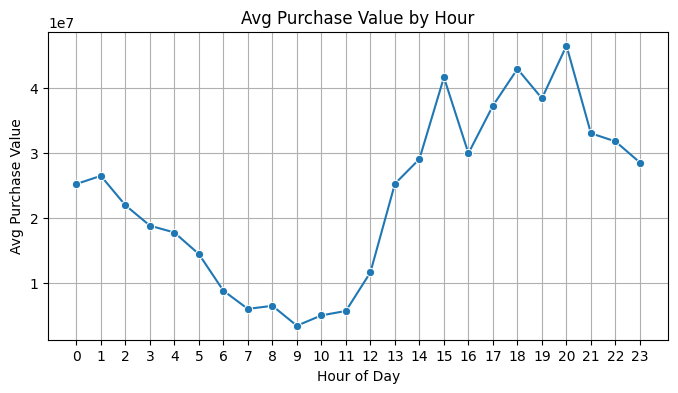

In [29]:
hourly = train_df.groupby('hour')['purchaseValue'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.lineplot(x='hour', y='purchaseValue', data=hourly, marker='o')
plt.title('Avg Purchase Value by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Avg Purchase Value')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


**Hourly Purchase Patterns – Insights and Interpretation**


- Lowest activity: 6–10 AM (min ~3.5M at 9 AM).  
- Pickup from midday; peak 3–8 PM, highest at 8 PM (~46.4M).  
- Decline after 8 PM but still relatively high.  

**Insight:** Purchases concentrate in afternoon/evening, reflecting typical workday routines or after-work shopping.




### **Monthly Seasonality**

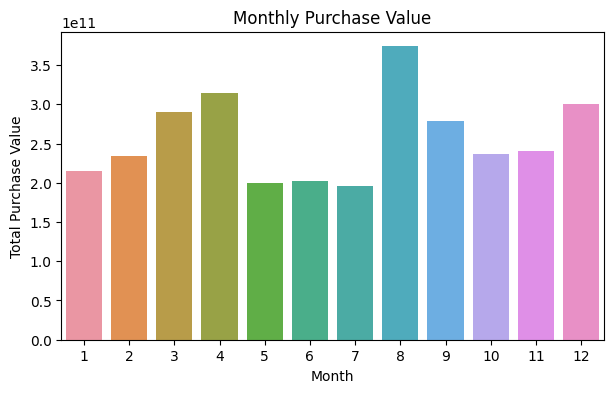

In [30]:
monthly = train_df.groupby('date_month')['purchaseValue'].sum().reset_index()

plt.figure(figsize=(7, 4))
sns.barplot(x='date_month', y='purchaseValue', data=monthly)
plt.title('Monthly Purchase Value')
plt.xlabel('Month')
plt.ylabel('Total Purchase Value')
plt.show()


**Monthly Seasonality – Insights & Interpretation**

- **Highest:** August (~374B), April (~314B), March (~290B), December (~301B).  
- **Lowest:** May (~199B), June (~203B), July (~196B).  
- Early spring and late summer show peaks; mid-summer sees dips.  

**Insight:** Clear seasonal patterns suggest marketing campaigns or promotions could be timed accordingly.



### **Week-wise Aggregation**

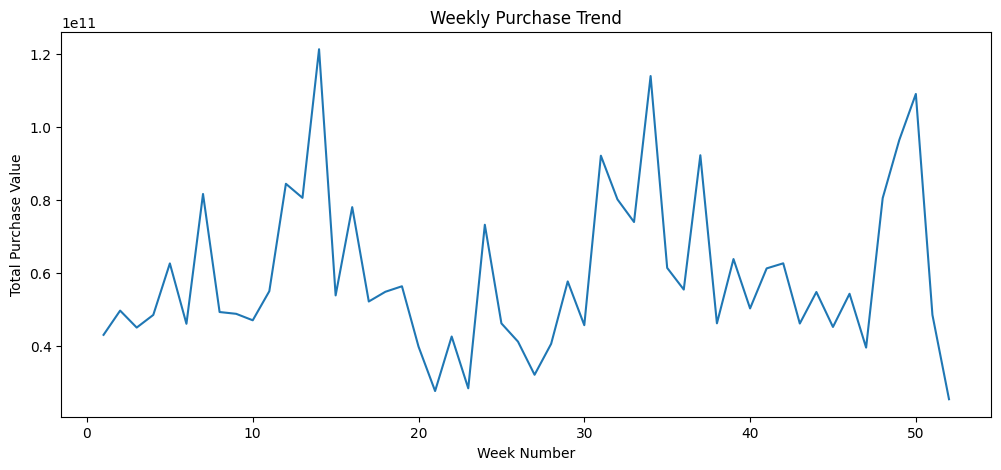

In [31]:
weekly = train_df.groupby('date_week')['purchaseValue'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(x='date_week', y='purchaseValue', data=weekly)
plt.title('Weekly Purchase Trend')
plt.xlabel('Week Number')
plt.ylabel('Total Purchase Value')
plt.show()

**Weekly Purchase Trends – Insights & Interpretation**

- Peaks: Weeks 14 (~121B), 34 (~114B), 50 (~109B); other high weeks >80B.  
- Lows: Weeks 21–23, 27, 52 (~25–28B).  
- Fluctuating weekly values indicate dynamic purchase activity.




### **Heatmap: Hour vs Day of Week**

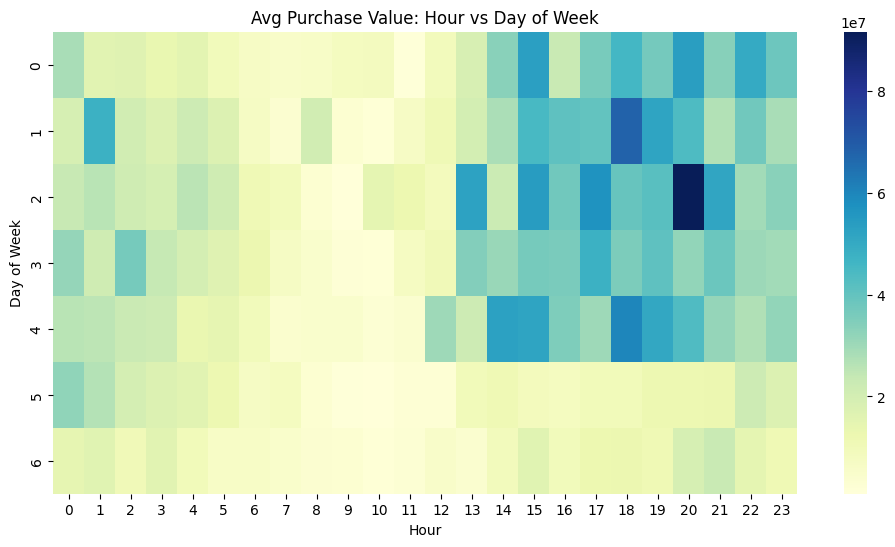

In [32]:
heatmap_data = train_df.pivot_table(index='day_of_week', columns='hour', values='purchaseValue', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Avg Purchase Value: Hour vs Day of Week')
plt.xlabel('Hour')
plt.ylabel('Day of Week')
plt.show()


**Heatmap Analysis: PurchaseValue by Hour and Day of Week**

- Weekdays: Low early mornings (0–7 AM), peak mid-afternoon to early evening (14:00–20:00), especially Monday & Wednesday.  
- Weekends: Lower overall activity; minor midday spikes.  
- Across all days: Very early hours (0–5 AM) show minimal purchases.



**Conclusion: Time-Based EDA & Its Modeling Impact**

Time-based analysis shows clear patterns in purchase behavior across days, hours, weeks, and months:

- **Weekly & Daily Cycles:** Peaks midweek (especially Wednesday) and during weekday afternoons/evenings; low activity on weekends and early mornings.  
- **Seasonality:** August and April exhibit major purchase spikes.  
- **Weekly Variations:** Certain weeks show pronounced highs and lows, likely tied to events or business cycles.  
- **Skewed Distribution:** Median purchases often 0; averages driven by a few large values.

**Modeling Implications:**  
- Temporal features (day, hour, week, month) are strong predictors.  
- Including time-based variables improves forecasting accuracy.  
- Insights support targeted marketing, campaign timing, and user segmentation.


In summary, Time-based EDA informs feature engineering, enhances predictive performance, and guides strategic decision-making.

# **TRAIN TEST SPLIT**


- **Training set:** Used to fit the model.  
- **Test set:** Used to evaluate performance on unseen data.  

**Why split before preprocessing:**  
- Prevents **data leakage** — ensures the model does not access test information during training.  

**Best Practice:**  
1. Split data first (70–80% train, 20–30% test).  
2. Apply preprocessing **only on training data**, then use the same transformations on the test set.


In [33]:
from sklearn.model_selection import train_test_split

In [34]:
y = train_df['purchaseValue']
X = train_df.drop(columns=['purchaseValue'])

stratify_mask = (y > 0).astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=stratify_mask, random_state=42)

# **DATA PREPROCESSING**


**Purpose:** Prepare raw data for modeling by creating clean, consistent, and ML-ready features.

**Key Steps:**  
- **Missing values:** Impute or remove.  
- **Categorical encoding:** One-hot, label, or target encoding.  
- **Feature scaling:** Normalize or standardize.  
- **Other steps:** Handle outliers, extract features, or reduce dimensionality.

In [35]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox

### Drop Uninformative or Redundant Features

**Drop Uninformative Features (Constant / Low Variance / High Missingness)**

- Constant or quasi-constant columns (low variance / low entropy).  
- Columns with >90% missing values.

**Drop Redundant / Highly Correlated Features**

Based on VIF & Correlation Analysis in EDA:

 - **Time features:** Drop `date_month`, `date_week`, `date_day`, `date_dayofweek`; keep `month`, `day`, `day_of_week`.  

- **Highly correlated features:** `totalHits` vs `pageViews` → drop `totalHits`.  

- **Low correlation with target:** Drop `gclIdPresent`, `trafficSource.adwordsClickInfo.page`.



### Handle Missing Values


| Feature                      | % Missing | Strategy                     | Notes                                    |
| ---------------------------- | --------- | ---------------------------- | ---------------------------------------- |
| `trafficSource.referralPath` | 63.2%     | Fill with `'Unknown'`         | Categorical, sparse                       |
| `trafficSource.isTrueDirect` | 63.0%     | Fill with `'Unknown'`/mode    | Binary, low entropy                        |
| `trafficSource.keyword`      | 61.9%     | Fill with `'Unknown'`         | High cardinality, sparse                   |
| `totals.bounces`             | 59.4%     | Fill with 0 or mode           | Binary                                     |
| `new_visits`                 | 30.6%     | Fill with 0                   | Binary                                     |
| `pageViews`                  | 0.01%     | Fill with median              | Numeric, very few missing                  |
| **Other numeric columns**    | —         | Fill with median              | —                                         |
| **Other categorical columns**| —         | Fill with mode or `'Unknown'`| —                                         |

## **DATA TRANSFORMATION**

### **Feature Transformation**


**Need for feature transformation**

EDA revealed highly skewed numerical features:

| Feature         | Skewness |
| --------------- | -------- |
| `sessionNumber` | 20.44    |
| `pageViews`     | 5.78     |

**Implications of high skewness:**  
- Presence of outliers.  
- Most data points clustered at lower values.  
- Violates model assumptions (e.g., normality for linear regression).  
- Can lead to poor or biased predictions.


#### **Log1p vs Yeo-Johnson vs Box Cox**


**Transformation Techniques Used**

1. **Log1p:** `log(1 + x)`; reduces right skew; works on non-negative values.  
2. **Yeo-Johnson:** Handles zero and negative values; learns optimal lambda to reduce skewness.  
3. **Box-Cox:** Learns best-fit power; only for strictly positive values. 


Skewness Before and After Transformations:



,Original,Log1p,Yeo-Johnson,Box-Cox
sessionNumber,20.65,3.11,0.96,0.92
pageViews,6.10,0.89,0.35,0.27


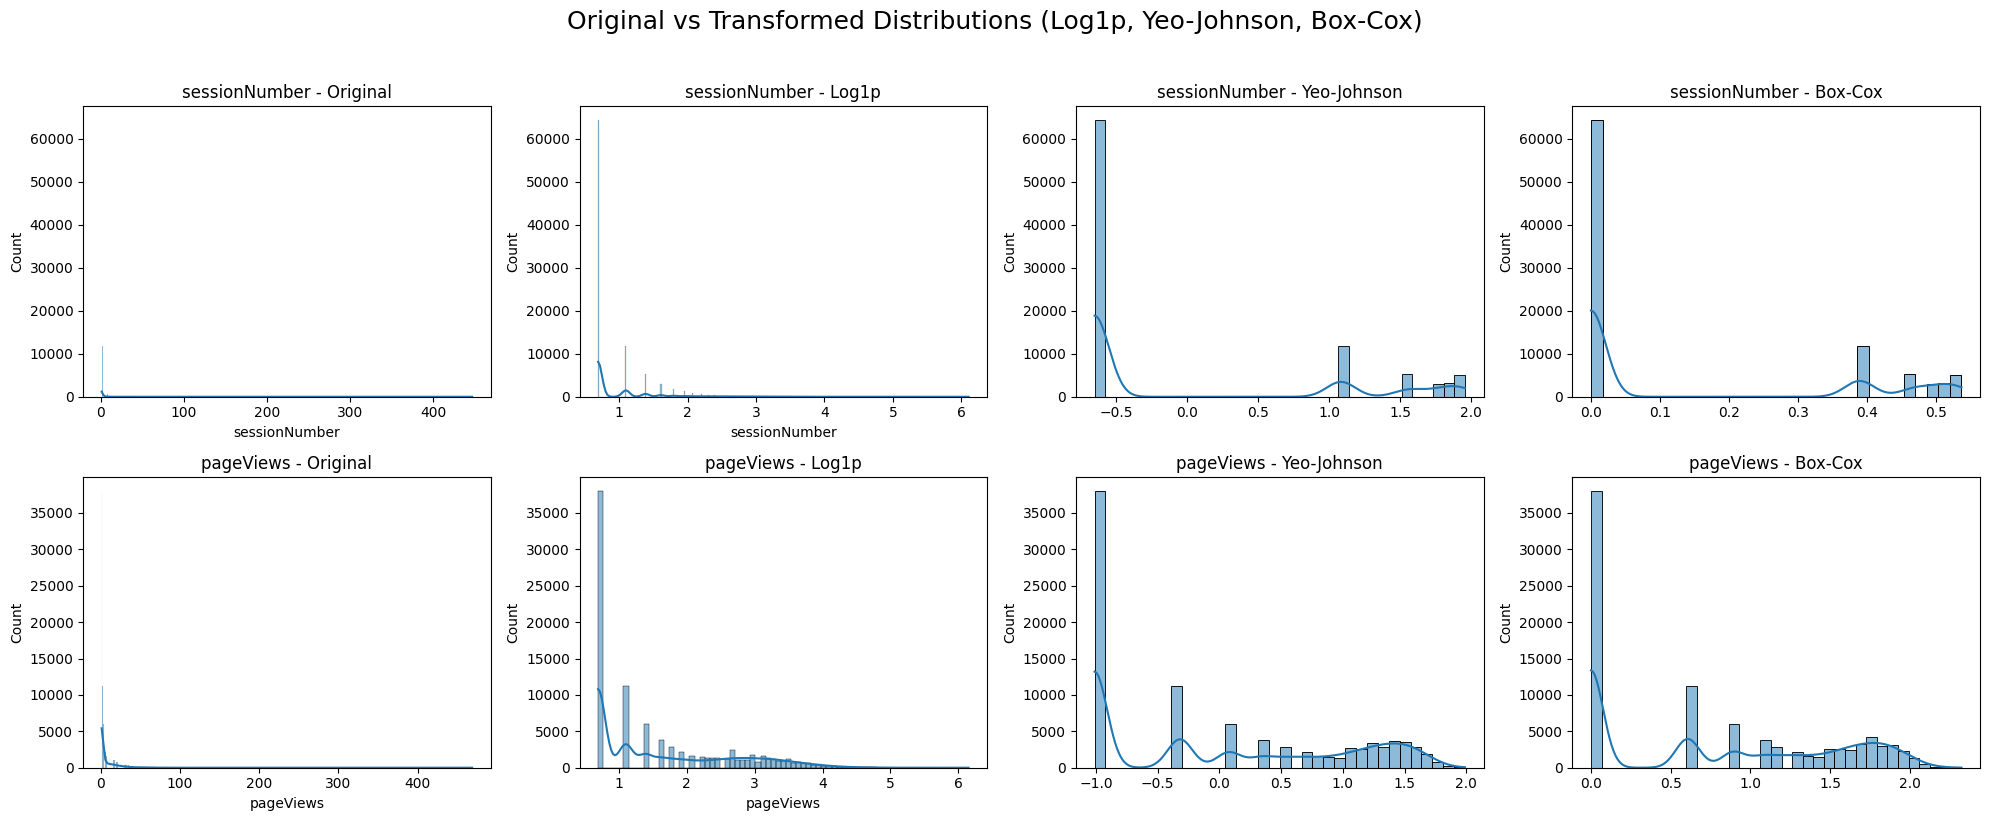

In [36]:

skewed_features = ['sessionNumber', 'pageViews']

skew_results = {}

n_feats = len(skewed_features)
fig, axes = plt.subplots(n_feats, 4, figsize=(20, 4 * n_feats))
fig.suptitle("Original vs Transformed Distributions (Log1p, Yeo-Johnson, Box-Cox)", fontsize=18, y=1.02)

for i, feature in enumerate(skewed_features):
    original = X_train[feature].dropna()

    # Original
    axes[i, 0].set_title(f"{feature} - Original")
    sns.histplot(original, kde=True, ax=axes[i, 0])
    original_skew = skew(original)
    
    # Log1p
    log1p_transformed = np.log1p(original)
    axes[i, 1].set_title(f"{feature} - Log1p")
    sns.histplot(log1p_transformed, kde=True, ax=axes[i, 1])
    log1p_skew = skew(log1p_transformed)
    
    # Yeo-Johnson
    pt_yeo = PowerTransformer(method='yeo-johnson')
    yeo_transformed = pt_yeo.fit_transform(original.values.reshape(-1, 1)).flatten()
    axes[i, 2].set_title(f"{feature} - Yeo-Johnson")
    sns.histplot(yeo_transformed, kde=True, ax=axes[i, 2])
    yeo_skew = skew(yeo_transformed)

    # Box-Cox (only if all values > 0)
    if (original > 0).all():
        boxcox_transformed, _ = boxcox(original)
        axes[i, 3].set_title(f"{feature} - Box-Cox")
        sns.histplot(boxcox_transformed, kde=True, ax=axes[i, 3])
        boxcox_skew = skew(boxcox_transformed)
    else:
        axes[i, 3].axis('off')
        boxcox_skew = 'N/A'

    skew_results[feature] = {
        'Original': round(original_skew, 2),
        'Log1p': round(log1p_skew, 2),
        'Yeo-Johnson': round(yeo_skew, 2),
        'Box-Cox': round(boxcox_skew, 2) if boxcox_skew != 'N/A' else 'N/A'
    }

plt.tight_layout()
plt.subplots_adjust(top=0.9)

skew_df = pd.DataFrame(skew_results).T
print("Skewness Before and After Transformations:\n")
display(skew_df)


**Interpretation**


| Feature         | Original Skew | Log1p | Yeo-Johnson | Box-Cox |
| --------------- | ------------- | ----- | ----------- | ------- |
| sessionNumber   | 20.44         | 3.11  | 0.96        | 0.92    |
| pageViews       | 5.78          | 0.89  | 0.35        | 0.27    |

**Interpretation & Recommendation:**  
- **sessionNumber:** Box-Cox gives lowest skew (0.92), Yeo-Johnson close (0.96). Use **Yeo-Johnson** for safety with 0s or potential negatives.  
- **pageViews:** Box-Cox gives lowest skew (0.27); since all values are positive, **Box-Cox** is ideal.


In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 low_var_threshold=0.999,
                 high_missing_threshold=0.90,
                 cardinality_threshold=25,
                 verbose=False):
        self.low_var_threshold = low_var_threshold
        self.high_missing_threshold = high_missing_threshold
        self.cardinality_threshold = cardinality_threshold
        self.verbose = verbose

        # Precomputed
        self.low_variance_cols = []
        self.high_missing_cols = []
        self.correlated_cols_to_drop = [
            'date_month', 'date_week', 'date_day',
            'date_dayofweek', 'totalHits',
            'gclIdPresent', 'trafficSource.adwordsClickInfo.page'
        ]
        self.columns_to_drop_ = []
        self.imputed_columns_ = []
        self.transformed_columns_ = []

        # Transformers
        self.yeo_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
        self.pageviews_lambda = None

        # Column roles
        self.low_card_cols = []
        self.high_card_cols = []
        self.numeric_cols = []
        self.final_features_ = []

    def fit(self, X, y=None):
        X = X.copy()

        # --- 1. Identify Low Variance & High Missingness ---
        for col in X.columns: 
            top_freq = X[col].value_counts(normalize=True, dropna=False).values[0]
            if top_freq >= self.low_var_threshold:
                self.low_variance_cols.append(col)

        self.high_missing_cols = X.columns[X.isnull().mean() > self.high_missing_threshold].tolist()

        self.columns_to_drop_ = sorted(
            set(self.low_variance_cols + self.high_missing_cols + self.correlated_cols_to_drop)
        )

        # --- 2. Drop columns for fitting imputation & transformation ---
        X = X.drop(columns=self.columns_to_drop_, errors='ignore')

        # --- 3. Imputation on a copy for fitting ---
        X = self._impute(X, fit=True)

        # --- 4. Fit PowerTransformers ---
        if 'sessionNumber' in X.columns:
            self.yeo_transformer.fit(X[['sessionNumber']])
            self.transformed_columns_.append('sessionNumber')

        if 'pageViews' in X.columns:
            valid = X['pageViews'].dropna()
            if (valid <= 0).any():
                if self.verbose:
                    print("Skipping Box-Cox for pageViews due to non-positive values.")
                self.pageviews_lambda = None
            else:
                _, self.pageviews_lambda = boxcox(valid)
                self.transformed_columns_.append('pageViews')

        # --- 5. Track feature types ---
        self.numeric_cols = X.select_dtypes(include='number').columns.tolist()
        cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

        self.low_card_cols = [col for col in cat_cols if X[col].nunique() <= self.cardinality_threshold]
        self.high_card_cols = [col for col in cat_cols if X[col].nunique() > self.cardinality_threshold]

        self.final_features_ = X.columns.tolist()
        if self.verbose:
            print("Dropped columns:", self.columns_to_drop_)
            print("Imputed columns:", self.imputed_columns_)
            print("Transformed columns:", self.transformed_columns_)
            print("Low-card categorical:", self.low_card_cols)
            print("High-card categorical:", self.high_card_cols)

        return self

    def transform(self, X):
        X = X.copy()

        # Drop columns
        X = X.drop(columns=self.columns_to_drop_, errors='ignore')

        # Impute
        X = self._impute(X, fit=False)

        # Transform numerical features
        if 'sessionNumber' in X.columns:
            X['sessionNumber'] = self.yeo_transformer.transform(X[['sessionNumber']])
        if 'pageViews' in X.columns and self.pageviews_lambda is not None:
            X['pageViews'] = boxcox(X['pageViews'], lmbda=self.pageviews_lambda)

        return X

    def _impute(self, X, fit=False):
        X = X.copy()

        imputed_cols = set()
        # Categorical imputations
        if 'trafficSource.referralPath' in X.columns:
            X['trafficSource.referralPath'] = X['trafficSource.referralPath'].fillna('unknown_ref')
            imputed_cols.add('trafficSource.referralPath')

        if 'trafficSource.isTrueDirect' in X.columns:
            X['trafficSource.isTrueDirect'] = X['trafficSource.isTrueDirect'].fillna(
                X['trafficSource.isTrueDirect'].mode()[0])
            imputed_cols.add('trafficSource.isTrueDirect')

        if 'trafficSource.keyword' in X.columns:
            X['trafficSource.keyword'] = X['trafficSource.keyword'].fillna('unknown_keyword')
            imputed_cols.add('trafficSource.keyword')

        # Numeric imputations
        if 'totals.bounces' in X.columns:
            X['totals.bounces'] = X['totals.bounces'].fillna(0)
            imputed_cols.add('totals.bounces')
        if 'new_visits' in X.columns:
            X['new_visits'] = X['new_visits'].fillna(0)
            imputed_cols.add('new_visits')
        if 'pageViews' in X.columns:
            X['pageViews'] = X['pageViews'].fillna(X['pageViews'].median())
            imputed_cols.add('pageViews')

         # Automatic imputation for other missing values
        for col in X.columns:
            if col in imputed_cols or not X[col].isnull().any():
                continue

            if pd.api.types.is_numeric_dtype(X[col]):
                X[col] = X[col].fillna(X[col].median())
            else:
                mode = X[col].mode()
                X[col] = X[col].fillna(mode.iloc[0] if not mode.empty else 'unknown')
            
            if fit:
                self.imputed_columns_.append(col)

        return X

    def get_feature_names_out(self, input_features=None):
        return self.final_features_ if self.final_features_ else input_features


### Target Transformation

Text(0.5, 1.0, 'Purchase Value Distribution (Only Non-Zero)')

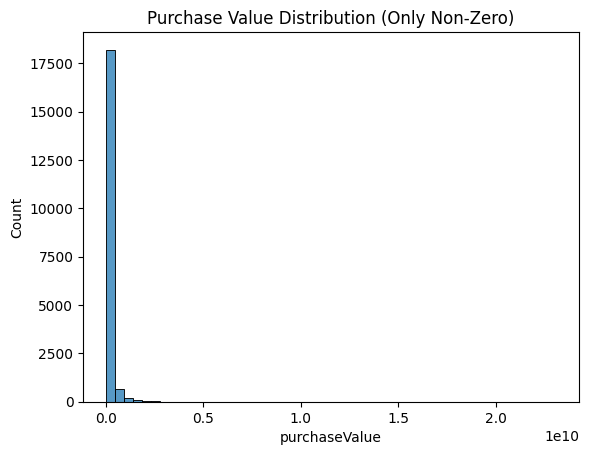

In [38]:
# Separate Plot for purchaseValue > 0
sns.histplot(y_train[y_train > 0], bins=50)
plt.title("Purchase Value Distribution (Only Non-Zero)")

Text(0.5, 1.0, 'Log-Transformed Purchase Value (Non-Zero Only)')

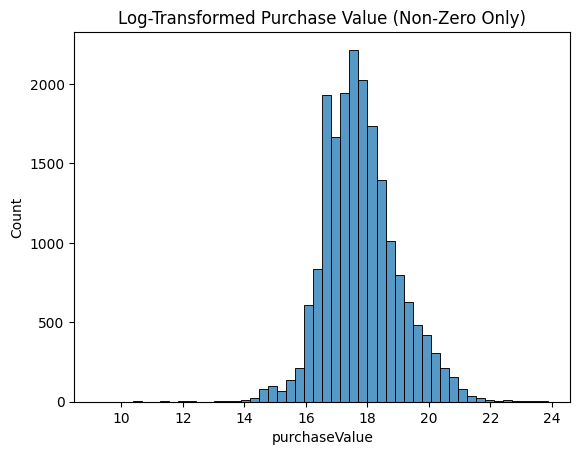

In [39]:

sns.histplot(np.log1p(y_train[y_train > 0]), bins=50)
plt.title("Log-Transformed Purchase Value (Non-Zero Only)")


In [40]:
purchase_rate = (y_train > 0).mean()
print(f"Purchase Rate: {purchase_rate:.2%}")

Purchase Rate: 20.67%




**Insights:**  

- ~79% of sessions have `purchaseValue = 0` → highly zero-inflated.  
- Positive values are still skewed; `log1p` makes them approximately normal.  
- Purchase rate ≈ 21%, suggesting a separate classification step is beneficial.

**Recommended Approach: Two-Stage Modeling**

1. **Classification (Purchase or Not)**  
   - Target: `purchaseFlag` = 1 if `purchaseValue > 0`, else 0  
   - Goal: Predict probability of purchase  
   - Models: Logistic Regression, Random Forest, XGBoost, etc.

2. **Regression (Conditional on Purchase)**  
   - Train on rows with `purchaseValue > 0`  
   - Target: `log1p(purchaseValue)`  
   - Models: Linear Regression, Gradient Boosting, etc.  
   - At inference: Apply `expm1()` to get original scale



In [41]:
def transform_target(y: pd.Series):
    # Step 1: Binary target for classification
    y_binary = (y > 0).astype(int)

    # Step 2: Log target for regression (only for purchasers)
    non_zero_idx = y > 0
    y_log = pd.Series(0.0, index=y.index)
    y_log[non_zero_idx] = np.log1p(y[non_zero_idx])

    print(f"Skew of original (non-zero): {skew(y[non_zero_idx]):.2f}")
    print(f"Skew of log-transformed (non-zero): {skew(y_log[non_zero_idx]):.2f}")
    return y_binary, y_log


## **User Session Aggregation**


**Purpose:**  

Generate user- and session-level aggregate features from raw interaction logs to capture behavioral patterns and improve model performance, while preventing data leakage.

**User-Level Features (by `userId`):**  
- `user_total_sessions`: Total sessions per user  
- `user_avg_pageViews`, `user_total_pageViews`, `user_std_pageViews`: Avg, total, variability in page views  
- `user_recency`, `user_last_session_gap`: Time between first/last session, days since last session  
- `user_session_freq`: Sessions per day  

**Session-Level Features (by `sessionId`):**  
- `session_total_pageViews`, `session_bounces`, `session_avg_pageViews_per_hour`  
- `session_is_mobile_rate`, `session_bounce_flag`, `session_duration`  

**Modeling Significance:**  
- Captures behavioral trends and temporal signals  
- Reduces dimensionality versus raw event data  
- Prevents data leakage  
- Handles unseen users/sessions robustly  
- Enhances predictive power for conversion and engagement metrics


In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

class UserSessionAggregator(BaseEstimator, TransformerMixin):
    """
    Extracts user-level and session-level aggregate features.
    Learns from training data (fit) and applies to val/test (transform)
    using only training-derived aggregates to prevent leakage.
    """

    def __init__(self, verbose=False):
        self.user_agg_ = None
        self.session_agg_ = None
        self.latest_day_ = None
        self.agg_medians_ = {}
        self.features_ = []
        self.verbose = verbose

    def fit(self, X, y=None):
        X = X.copy()
        self.latest_day_ = X['day'].max()

        required_cols = ['userId', 'sessionId', 'pageViews', 'new_visits', 'day']
        missing_cols = [col for col in required_cols if col not in X.columns]
        if missing_cols:
            raise KeyError(f"Missing columns required for aggregation: {missing_cols}")

        # --- User-level aggregates ---
        user_agg = X.groupby('userId').agg(
            user_total_sessions=('sessionId', 'nunique'),
            user_avg_pageViews=('pageViews', 'mean'),
            user_last_day=('day', 'max'),
            user_first_day=('day', 'min'),
            user_avg_new_visits=('new_visits', 'mean'),
            user_total_pageViews=('pageViews', 'sum'),
            user_max_pageViews=('pageViews', 'max'),
            user_std_pageViews=('pageViews', 'std'),
        )

        user_agg.fillna(0, inplace=True)

        user_agg['user_recency'] = user_agg['user_last_day'] - user_agg['user_first_day']
        user_agg['user_session_freq'] = user_agg['user_total_sessions'] / (user_agg['user_recency'] + 1)
        user_agg['user_last_session_gap'] = self.latest_day_ - user_agg['user_last_day']

        user_agg.drop(columns=['user_last_day', 'user_first_day'], inplace=True)
        self.user_agg_ = user_agg

        # --- Session-level aggregates ---
        session_agg = X.groupby('sessionId').agg(
            session_total_pageViews=('pageViews', 'sum'),
            session_bounces=('totals.bounces', 'sum'),
            session_hour_min=('hour', 'min'),
            session_hour_max=('hour', 'max'),
            session_is_mobile_rate=('device.isMobile', 'mean'),
            session_avg_new_visits=('new_visits', 'mean')
        )

        session_agg.fillna(0, inplace=True)

        session_agg['session_duration'] = session_agg['session_hour_max'] - session_agg['session_hour_min']
        session_agg['session_duration'] = session_agg['session_duration'].clip(lower=1)
        session_agg['session_avg_pageViews_per_hour'] = (
            session_agg['session_total_pageViews'] / session_agg['session_duration']
        )
        session_agg['session_bounce_flag'] = (session_agg['session_bounces'] > 0).astype(int)

        session_agg.drop(columns=['session_hour_min', 'session_hour_max'], inplace=True)
        self.session_agg_ = session_agg

        self.agg_medians_ = {
            **self.user_agg_.median(numeric_only=True).to_dict(),
            **self.session_agg_.median(numeric_only=True).to_dict()
        }

        if self.verbose:
            print("User aggregates shape:", user_agg.shape)
            print("Session aggregates shape:", session_agg.shape)
            print("Cached medians:", self.agg_medians_)

        return self

    def transform(self, X):
        X = X.copy()
        X_original_index = X.index 

        # Merge aggregates (left join to avoid leakage)
        X = X.merge(self.user_agg_, how='left', on='userId')
        X = X.merge(self.session_agg_, how='left', on='sessionId')

        # Impute missing values for new users/sessions not in training
        for col in self.user_agg_.columns.tolist() + self.session_agg_.columns.tolist():
            if col not in X.columns:
                continue
            if pd.api.types.is_numeric_dtype(X[col]):
                if col == 'session_duration':
                    X[col] = X[col].fillna(1)
                elif col == 'user_last_session_gap':
                    X[col] = X[col].fillna(self.latest_day_)
                elif col in self.agg_medians_:
                    X[col] = X[col].fillna(self.agg_medians_[col])
                else:
                    X[col] = X[col].fillna(0)  # fallback
            else:
                X[col] = X[col].fillna('unknown')

        X.drop(columns=['userId', 'sessionId'], inplace=True, errors='ignore')

        X.index = X_original_index

        self.features_ = X.columns.tolist()

        return X

    def get_feature_names_out(self, input_features=None):
        return self.features_



## **Encoding**


**Purpose:** Convert categorical variables into numerical values so ML algorithms can interpret them.

**Why It Matters:**  

1. Most ML models require numeric input.  
2. Preserves information in categorical features (e.g., country, device, referral source).  
3. Improves model performance, generalization, and training efficiency.

**Common Encoding Techniques:**

| Type                 | Use Case                                   | Description                                                                 |
| -------------------- | ----------------------------------------- | --------------------------------------------------------------------------- |
| One-Hot Encoding     | Low-cardinality features                   | Creates a binary column per category.                                       |
| Label Encoding       | Ordinal data                               | Assigns integer labels (not for non-ordinal).                               |
| Target Encoding      | Mid/high-cardinality, predictive features | Replaces categories with mean target value (use CV to avoid leakage).       |
| Top-N Encoding       | Very high-cardinality features             | Keeps top N frequent categories, groups others as `'__OTHER__'`.            |


In [43]:
from sklearn.model_selection import KFold

def target_encode_cv(X: pd.DataFrame, y: pd.Series, col: str, n_splits: int = 5) -> pd.Series:
    """
    Cross-validated target encoding to avoid data leakage.
    Applies K-fold mean encoding on a categorical feature.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    encoded = pd.Series(index=X.index, dtype=float)

    for train_idx, val_idx in kf.split(X):
        train_X, val_X = X.iloc[train_idx], X.iloc[val_idx]
        train_y = y.iloc[train_idx]

        means = train_y.groupby(train_X[col]).mean()
        encoded.loc[val_X.index] = val_X[col].map(means)

    # Fill missing categories with global mean
    return encoded.fillna(y.mean())

In [44]:
class CustomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, top_n_high_card=50, use_target_encoding=True, use_top_n_encoding=True, cv_splits=5, verbose=False):
        self.top_n_high_card = top_n_high_card
        self.use_target_encoding = use_target_encoding
        self.use_top_n_encoding = use_top_n_encoding
        self.cv_splits = cv_splits
        self.verbose = verbose
        self.target_encoding_maps = {}
        self.top_n_categories = {}
        self.one_hot_columns = []
        self.target_enc_cols = []
        self.high_card_cols = []
        self.columns_after_encoding = []
        self._is_fitted = False

    def fit(self, X: pd.DataFrame, y: pd.Series):
        if self.use_target_encoding and y is None:
            raise ValueError("Target values `y` are required for target encoding.")
       
        X = X.copy()
        self.cat_cols = X.select_dtypes(include='object').columns
        cardinality = X[self.cat_cols].nunique()
        
        self.one_hot_columns = cardinality[cardinality <= 10].index.tolist()
        self.target_enc_cols = cardinality[(cardinality > 10) & (cardinality <= 100)].index.tolist()
        self.high_card_cols = cardinality[cardinality > 100].index.tolist()
        
        # Fit target encodings
        if self.use_target_encoding:
            for col in self.target_enc_cols:
                self.target_encoding_maps[col] = y.groupby(X[col]).mean()

        # Record top-N categories for high-card cols
        if self.use_top_n_encoding:
            for col in self.high_card_cols:
                top_n = X[col].value_counts().nlargest(self.top_n_high_card).index.tolist()
                self.top_n_categories[col] = top_n


        X_encoded = self._encode(X.copy(), y)
        self.columns_after_encoding = X_encoded.columns

        self._is_fitted = True

        if self.verbose:
            print("One-hot columns:", self.one_hot_columns)
            print("Target-encoded columns:", self.target_enc_cols)
            print("High-cardinality columns (Top-N):", self.high_card_cols)
        
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series = None) -> pd.DataFrame:
        X = X.copy()

        if not self._is_fitted:
            raise RuntimeError("CustomEncoder must be fitted before calling transform.")
        
        return self._encode(X.copy(), y)
    
    def _encode(self, X: pd.DataFrame, y: pd.Series = None) -> pd.DataFrame:
    
        # === 1. One-Hot Encoding for low-card cols ===
        X = pd.get_dummies(X, columns=self.one_hot_columns, drop_first=True)

        # === 2. Target Encoding ===
        if self.use_target_encoding:
            for col in self.target_enc_cols:
                if y is not None:
                    # Apply CV target encoding during training
                    X[col + '_te'] = target_encode_cv(X, y, col, n_splits=self.cv_splits)
                else:
                    # Use stored mean mapping at inference
                    means = self.target_encoding_maps[col]
                    X[col + '_te'] = X[col].map(means).fillna(means.mean())
                X.drop(columns=col, inplace=True)
        else:
            X = pd.get_dummies(X, columns=self.target_enc_cols, drop_first=True)

        # === 3. Top-N Encoding ===
        if self.use_top_n_encoding:
            for col in self.high_card_cols:
                top_n = self.top_n_categories[col]
                X[col] = X[col].where(X[col].isin(top_n), '__OTHER__')
                X = pd.get_dummies(X, columns=[col], drop_first=True)
        else:
            X = pd.get_dummies(X, columns=self.high_card_cols, drop_first=True)

        # Align to training columns (in case of missing dummies)
        if len(self.columns_after_encoding) > 0:
            missing_cols = set(self.columns_after_encoding) - set(X.columns)
            for col in missing_cols:
                X[col] = 0
            X = X[self.columns_after_encoding]

        return X
    
    def get_feature_names_out(self, input_features=None):
        return self.columns_after_encoding.tolist()



**Implementation:**

`CustomEncoder` is a pipeline-friendly encoder that automatically selects the best method based on feature cardinality:

**Encoding Strategy by Cardinality**

| Cardinality          | Method                 | Details |
| ------------------- | -------------------- | ------- |
| ≤10 unique values    | One-Hot Encoding      | `pd.get_dummies` with `drop_first=True` to avoid multicollinearity. |
| 11–100 unique values | Target Encoding (CV)  | Replaces category with mean target; uses cross-validation to prevent leakage. |
| >100 unique values   | Top-N Encoding + OHE  | Keeps top-N frequent categories, groups others as `'__OTHER__'`, then applies one-hot encoding. |

**Benefits**

* Automatically adapts encoding to feature type.  
* Prevents overfitting in target encoding via CV.  
* Reduces dimensionality explosion for high-cardinality features.  
* Seamlessly integrates with ML pipelines.


## Sanitisation

Sanitizing column names is important to ensure **clean, consistent, and safe feature names** for processing, especially in automated pipelines or code that interacts with column names programmatically.


In [45]:
# Clean column names to remove special characters
def sanitize_cols_with_mapping(df):
    df = df.copy()
    original_cols = df.columns.tolist()
    sanitized_cols = (
        df.columns
        .str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)
        .str.strip('_')
    )
    col_mapping = dict(zip(sanitized_cols, original_cols))
    df.columns = sanitized_cols
    return df, col_mapping


# **MODEL TRAINING**

**Modeling Strategy for Zero-Inflated Target**

**Problem:** `purchaseValue` is heavily zero-inflated (~79% zeros) and right-skewed.

* Approach 1:  Single-Stage Regression (Not Ideal)
  - Struggles with predicting zeros vs non-zeros.
  - May **underpredict purchases** and **overpredict zeros**.

* Approach 2: Two-Stage Modeling (Recommended)

  - **Step 1: Classification**
    * Target: `purchaseFlag = 1 if purchaseValue > 0 else 0`
    * Predicts **whether a purchase occurs**
    * Handles class imbalance and separates **buy/no-buy decision** from purchase amount.

  - **Step 2: Regression**
    * Train on **rows where purchaseValue > 0**
    * Target: `log1p(purchaseValue)`
    * Predicts **purchase amount** for buyers
    * Log-transform reduces skewness and stabilizes predictions
    * Apply `expm1()` at inference to recover original scale.


## **BASE MODEL TRAINING**

- **Objective:** Build a first working version to check feasibility, performance bounds, and understand basic feature influences

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, r2_score, f1_score
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.pipeline import Pipeline

In [47]:

def hybrid_metric(y_true, y_pred):
    """
    Calculate R² on all samples, on purchasers only (i.e., y_true > 0) and
    Compute a hybrid score- Weighted sum: 70% overall R² + 30% purchaser R²
    """
    purchasers_mask = y_true > 0
    r2_all = r2_score(y_true, y_pred)
    r2_purchasers = r2_score(y_true[purchasers_mask], y_pred[purchasers_mask]) if purchasers_mask.sum() > 0 else 0
    hybrid_r2 = 0.7 * r2_all + 0.3 * r2_purchasers

    return hybrid_r2, r2_all, r2_purchasers


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    

### Applying Preprocessing Steps

In [48]:
y_train_binary, y_train_log = transform_target(y_train)
y_val_binary, y_val_log = transform_target(y_val)

assert y_train_log.index.equals(X_train.index)
assert y_val_log.index.equals(X_val.index)

preprocessing_pipeline = Pipeline([
    ('preprocessing', CustomPreprocessor()),
    ('aggregation', UserSessionAggregator())
])

preprocessing_pipeline.fit(X_train, y_train_log)

X_train_prep = preprocessing_pipeline.transform(X_train)
X_val_prep = preprocessing_pipeline.transform(X_val)

assert y_train_log.index.equals(X_train_prep.index)
assert y_val_log.index.equals(X_val_prep.index)

encoder = CustomEncoder()
encoder.fit(X_train_prep, y_train_log)
X_train_final = encoder.transform(X_train_prep, y_train_log)
X_val_final = encoder.transform(X_val_prep)

assert y_train_log.index.equals(X_train_final.index)
assert y_val_log.index.equals(X_val_final.index)


Skew of original (non-zero): 26.86
Skew of log-transformed (non-zero): 0.36
Skew of original (non-zero): 23.00
Skew of log-transformed (non-zero): 0.39


In [49]:
X_train.shape, X_train_prep.shape, X_train_final.shape

((92818, 58), (92818, 44), (92818, 358))

In [50]:
date_col_train = X_train_final['date']
date_col_val = X_val_final['date']

In [51]:
X_train_model = X_train_final.select_dtypes(exclude=['datetime64[ns]', 'datetime64'])
X_val_model = X_val_final.select_dtypes(exclude=['datetime64[ns]', 'datetime64'])

In [52]:
X_train_model, col_mapping = sanitize_cols_with_mapping(X_train_model)
X_val_model, col_mapping = sanitize_cols_with_mapping(X_val_model)

assert y_train_log.index.equals(X_train_model.index)
assert y_val_log.index.equals(X_val_model.index)


### Single Stage Model Training

Single Stage Modelling- Decision Tree Regressor
Evaluation Metrics:
MAE: 26141237.82
RMSE: 187821672.70

 Hybrid Evaluation Metrics:
  R² (All users):        -0.0059
  R² (Purchasers only):  -0.0928
  Hybrid R² (70/30 mix): -0.0320


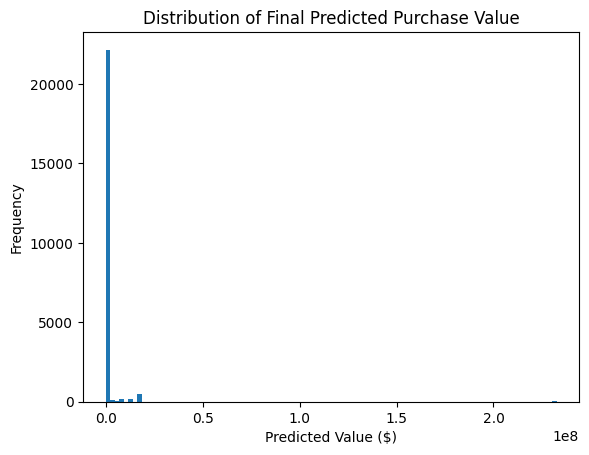

In [53]:

# Train single-stage regressor
dt_reg =  DecisionTreeRegressor(
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)

dt_reg.fit(X_train_model, y_train_log)

# Predict and Inverse transform
y_pred_log = dt_reg.predict(X_val_model)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_val_log)

# Evaluation
mae = mean_absolute_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)
hybrid_r2, r2_all, r2_purchasers = hybrid_metric(y_true, y_pred)

print(f"Single Stage Modelling- Decision Tree Regressor\nEvaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print("\n Hybrid Evaluation Metrics:")
print(f"  R² (All users):        {r2_all:.4f}")
print(f"  R² (Purchasers only):  {r2_purchasers:.4f}")
print(f"  Hybrid R² (70/30 mix): {hybrid_r2:.4f}")

plt.hist(y_pred, bins=100)
plt.title("Distribution of Final Predicted Purchase Value")
plt.xlabel("Predicted Value ($)")
plt.ylabel("Frequency")
plt.show()


**Single-Stage Regressor Performance (Decision Tree)**

**Observation:** Single-stage regression struggles with `purchaseValue` due to **zero-inflation** and **high skew**.

### Metrics (Decision Tree Regressor)
- **MAE:** 26M+ → high absolute error  
- **RMSE:** 187M+ → outliers dominate  
- **R² (All):** -0.0059 → worse than predicting the mean  
- **R² (Purchasers):** -0.0928 → poor on paying users  
- **Hybrid R²:** -0.0320 → weighted still negative  

### Key Issues
| Property            | Impact                                                       |
| ------------------- | ------------------------------------------------------------ |
| Highly skewed       | Bias toward low values                                       |
| Zero-inflated       | Model predicts zeros well but misses rare high purchases    |
| High variance       | Large RMSE, poor R² due to extreme outliers                 |

### Recommendation
1. **Two-Stage Modeling**  
   - Stage 1: Classify if a user will purchase  
   - Stage 2: Regress purchase amount **only on predicted buyers**

2. **Better Algorithms**  
   - Tree ensembles (XGBoost, LightGBM, CatBoost)  
   - Use custom objective functions for skewed targets


### Two Stage Model Training


In [54]:
from sklearn.preprocessing import StandardScaler

In [55]:

def train_and_evaluate_logistic_regression(X_train, y_train, X_val, y_val, description="Classification Metrics"):
    """
    Train logistic regression classifier, make predictions, evaluate and return results.
    
    """
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Train classifier
    clf = LogisticRegression(max_iter=1000, n_jobs=-1, class_weight='balanced')
    clf.fit(X_train_scaled, y_train)

    # Probabilities and labels
    y_pred_prob = pd.Series(clf.predict_proba(X_val_scaled)[:, 1], index=X_val.index)
    y_pred_label = pd.Series(clf.predict(X_val_scaled), index=X_val.index)

    # Evaluate classification
    f1 = f1_score(y_val, y_pred_label)
    roc_auc = roc_auc_score(y_val, y_pred_prob)

    print(f"\n {description}:")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    return y_pred_prob, y_pred_label


In [56]:
# === Classification Stage ===
y_pred_prob_model, y_pred_label_model = train_and_evaluate_logistic_regression(
    X_train_model, y_train_binary,
    X_val_model, y_val_binary,
    description="Classification Metrics on Full Feature Set"
)



 Classification Metrics on Full Feature Set:
F1 Score: 0.8271
ROC AUC: 0.9905


In [57]:

def train_and_evaluate_lgb_regressor(
    X_train, y_train_log, 
    X_val, y_val_log, 
    y, y_pred_prob,
    description="LightGBM Regression",
    threshold=0.05,
    plot=True
):
    """
    Train LightGBM regressor on purchasers, make predictions, compute soft targets, and evaluate.

    """

    # Filter purchasers for training
    purchasers_mask_train = y_train_log > 0
    X_train_reg = X_train[purchasers_mask_train]
    y_train_reg = y_train_log[purchasers_mask_train]

    purchasers_mask_val = y_val_log > 0
    X_val_reg = X_val[purchasers_mask_val]
    y_val_reg = y_val_log[purchasers_mask_val]

    lgb_train = lgb.Dataset(X_train_reg, label=y_train_reg)
    lgb_val = lgb.Dataset(X_val_reg, label=y_val_reg, reference=lgb_train)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "learning_rate": 0.07,
        "num_leaves": 64,
        "min_data_in_leaf": 30,
        "seed": 42
    }

    # Train model
    lgb_reg = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_val],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=300)],
    )

    
    y_pred_reg = pd.Series(0, index=y_pred_prob.index, dtype=float)

    # Predict only for high-confidence users
    above_threshold_idx = y_pred_prob > threshold
    X_val_reg_pred = X_val.loc[above_threshold_idx]
    
    y_pred_log_reg_sub = lgb_reg.predict(X_val_reg_pred, num_iteration=lgb_reg.best_iteration)
    y_pred_reg_sub = np.expm1(y_pred_log_reg_sub)

    y_pred_reg.loc[above_threshold_idx] = y_pred_reg_sub

    # Soft predictions
    y_pred_soft = y_pred_prob * y_pred_reg
    y_true_soft = y.loc[X_val.index]

    # Evaluation
    mae_soft = mean_absolute_error(y_true_soft, y_pred_soft)
    rmse_soft = root_mean_squared_error(y_true_soft, y_pred_soft) 
    hybrid_r2, r2_all, r2_purchasers = hybrid_metric(y_true_soft, y_pred_soft)

    print(f"\n Soft Prediction Evaluation with {description}:")
    print(f"MAE (Soft): {mae_soft:.2f}")
    print(f"RMSE (Soft): {rmse_soft:.2f}")
    print(f"  R² (All users):        {r2_all:.4f}")
    print(f"  R² (Purchasers only):  {r2_purchasers:.4f}")
    print(f"  Hybrid R² (70/30 mix): {hybrid_r2:.4f}")

    if plot:
        plt.hist(y_pred_soft, bins=100)
        plt.title(f"Distribution of Final Predicted Purchase Value ({description})")
        plt.xlabel("Predicted Value ($)")
        plt.ylabel("Frequency")
        plt.show()

    return lgb_reg


Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[797]	training's rmse: 0.460506	valid_1's rmse: 0.970679

 Soft Prediction Evaluation with LightGBM on Full Features:
MAE (Soft): 19138548.77
RMSE (Soft): 146011812.85
  R² (All users):        0.3921
  R² (Purchasers only):  0.3407
  Hybrid R² (70/30 mix): 0.3767


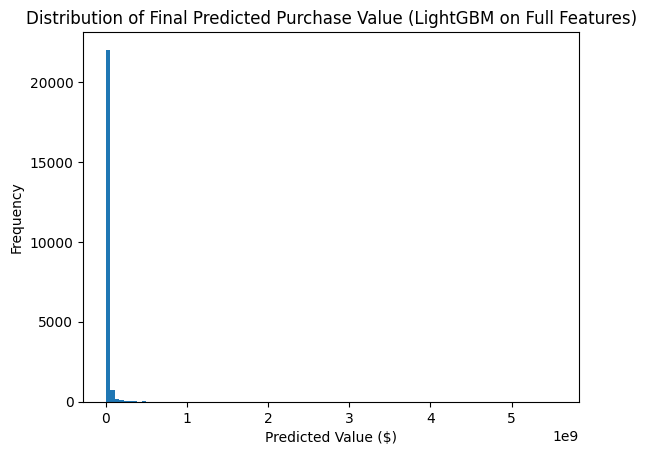

In [58]:
# === Regression Stage (for actual purchasers only) ===
lgb_model_full = train_and_evaluate_lgb_regressor(
    X_train_model, y_train_log,
    X_val_model, y_val_log,
    y, y_pred_prob_model,
    description="LightGBM on Full Features"
)



**Significant improvement** over single-stage regression (Decision Tree).


**Stage 1: Classification**

- **F1 Score:** 0.8271 → strong balance of precision & recall  
- **ROC AUC:** 0.9905 → excellent discrimination of purchasers vs non-purchasers

**Stage 2: Regression (LightGBM, buyers only)**

- **MAE:** 19.1M ↓ (from 26M)  
- **RMSE:** 146M ↓ (from 187M)  
- **R² (All users):** 0.3921 ↑ (from -0.0059)  
- **R² (Purchasers):** 0.3407 ↑ (from -0.0928)  
- **Hybrid R²:** 0.3767 ↑ (from -0.0320)  


**Why Two-Stage Modeling Works**

| Stage       | Task                                          | Why It Helps                                                      |
| ----------- | --------------------------------------------- | ---------------------------------------------------------------- |
| **Stage 1** | Classification: Will user purchase?           | Separates zeros from non-zeros, avoids polluting regression      |
| **Stage 2** | Regression: Predict revenue for buyers only  | Focuses model on meaningful values, improves accuracy & stability|

**Key Factors Driving Improvement**

| Factor                        | Impact                                                                 |
| ------------------------------ | --------------------------------------------------------------------- |
| Two-stage setup               | Handles zero-inflation effectively                                      |
| LightGBM model                | Captures complex patterns, deals with skew & high cardinality          |
| Soft prediction strategy      | Probabilistic weighting improves stability                              |
| Better features               | Aggregation, encoding, and transformations boost predictive power      |
| Custom hybrid R²              | Ensures strong performance both overall and on revenue-driving users  |


#### Feature Importance from LightGBM


- **Approach:** Rank features by LGBM importance (gain/frequency) → keep **top 20** → retrain model.  

**Importance:**
1. **Removes noise** → keeps only predictive features, reduces overfitting.  
2. **Improves generalization** → better performance on unseen data.  
3. **Faster training & inference** → fewer features, efficient production use.  
4. **Better interpretability** → easier to explain key drivers like `user_max_pageViews`, `os_te`, `session_total_pageViews`.

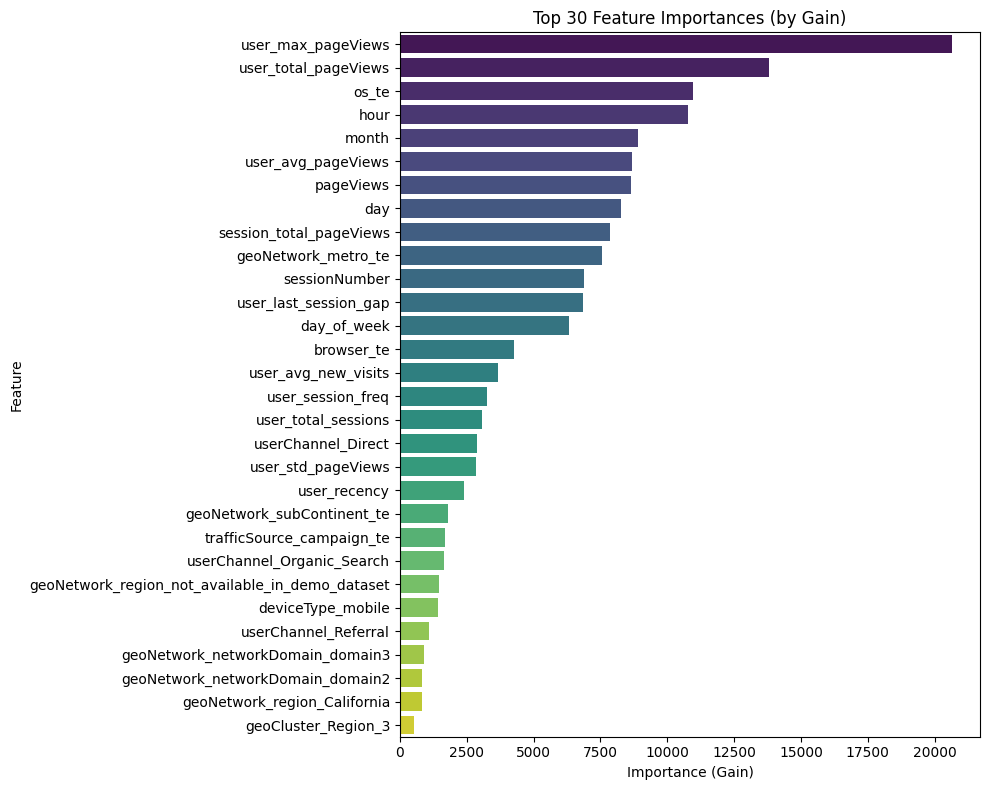

In [59]:
# Get feature importance
importance_df = pd.DataFrame({
    'feature': lgb_model_full.feature_name(),
    'importance': lgb_model_full.feature_importance(importance_type='gain')
}).sort_values(by='importance', ascending=False)


# Plot Top N features
TOP_N = 30
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(TOP_N), x='importance', y='feature', palette='viridis')
plt.title(f"Top {TOP_N} Feature Importances (by Gain)")
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [60]:
importance_df.head(20)

,feature,importance
14,user_max_pageViews,20665.022695
13,user_total_pageViews,13803.054830
54,os_te,10944.671340
6,hour,10793.169391
9,month,8900.261912
11,user_avg_pageViews,8675.438823
2,pageViews,8630.752316
7,day,8284.683121
19,session_total_pageViews,7840.431716
56,geoNetwork_metro_te,7566.244762


Key Insights

| Feature                   | Insight                                                      |
| ------------------------- | ------------------------------------------------------------ |
| `user_max_pageViews`      | Captures peak engagement per user                            |
| `user_total_pageViews`    | Proxy for overall activity                                    |
| `os_te`                   | Device/OS influences purchase behavior                        |
| `hour`, `day`, `month`    | Temporal patterns affect buying                                |
| `geoNetwork_metro_te`     | Regional differences matter                                   |
| `user_last_session_gap`   | Recent activity signals higher conversion intent             |
| `session_total_pageViews` | Session depth reflects interest/engagement                   |


# **FEATURE SELECTION**

Selecting **top 20 features** based on **LGBM feature importance** and training the model on them.

In [61]:
top_20_features = importance_df['feature'].head(20).to_list()
X_train_top20 = X_train_model[top_20_features]
X_val_top20   = X_val_model[top_20_features]


In [62]:
y_pred_prob_top20, y_pred_label_top20 = train_and_evaluate_logistic_regression(
    X_train_top20, y_train_binary,
    X_val_top20, y_val_binary,
    description="Classification Metrics on Top 20 Features"
)



 Classification Metrics on Top 20 Features:
F1 Score: 0.8327
ROC AUC: 0.9891


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[611]	training's rmse: 0.558934	valid_1's rmse: 0.967498

 Soft Prediction Evaluation with LightGBM on Top 20 Features:
MAE (Soft): 18735833.00
RMSE (Soft): 135118762.90
  R² (All users):        0.4794
  R² (Purchasers only):  0.4380
  Hybrid R² (70/30 mix): 0.4670


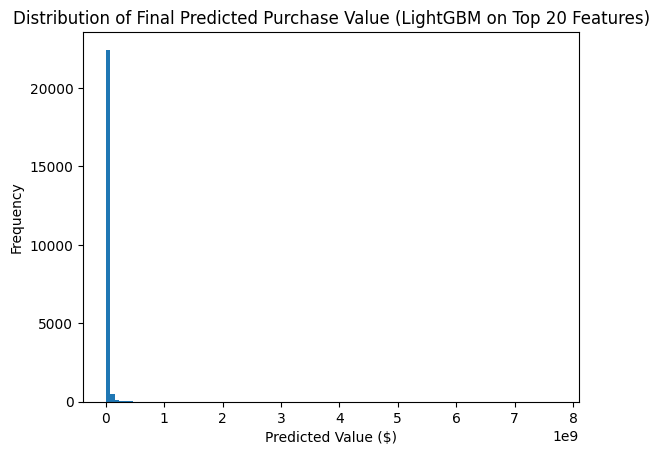

In [63]:
lgb_model_top20 = train_and_evaluate_lgb_regressor(
    X_train_top20, y_train_log,
    X_val_top20, y_val_log,
    y, y_pred_prob_top20,
    description="LightGBM on Top 20 Features"
)


**Model Performance: Full vs Top 20 Features**

1. Classification Metrics

| Metric       | Full Model | Top 20 Features | Change           |
| ------------ | ---------- | --------------- | ---------------- |
| F1 Score     | 0.8204     | 0.8327          | Slight gain      |
| ROC AUC      | 0.9912     | 0.9891          | Minor drop       |

**Interpretation:** Classifier remains very strong; minor AUC drop is negligible.


2. Regression Metrics (Revenue Prediction)

| Metric                   | Full Model | Top 20 Features | Change            |
| ------------------------ | ---------- | --------------- | ---------------- |
| MAE                      | 19.1M      | 18.7M           | Improved         |
| RMSE                     | 146M       | 135M            | Improved         |
| R² (All users)           | 0.3921     | 0.4794          | Major gain       |
| R² (Purchasers only)     | 0.3407     | 0.4380          | Major gain       |
| Hybrid R² (70/30)        | 0.3767     | 0.4670          | Strong gain      |

**Interpretation:**  
- Regression performance improved across all metrics.  
- Top 20 features reduce noise, improve generalization, and help the model focus on the strongest signals.  
- Slight drop in AUC is acceptable given the revenue prediction gains.


**Key Takeaways**

1. Feature selection improved regression performance.  
2. Minor classification trade-off is acceptable.  
3. Top features capture user/session behavior and high-impact categorical signals effectively.


# FEATURE ENGINEERING

##  Pre–feature engineering inspection

#### Pearson and Spearman Correlations

| Correlation Type | Measures                                   | Assumes                       | Sensitivity           | When to Use                                             |
| ---------------- | ----------------------------------------- | ----------------------------- | ------------------- | ------------------------------------------------------ |
| **Pearson**      | Linear relationship between continuous variables | Linear, normally distributed  | Sensitive to outliers | When relationship is expected to be linear            |
| **Spearman**     | Monotonic relationship (rank-based)       | None                          | Less sensitive to outliers | Skewed, ordinal, or non-linear relationships         |


In [64]:
from  sklearn.feature_selection._mutual_info import mutual_info_regression

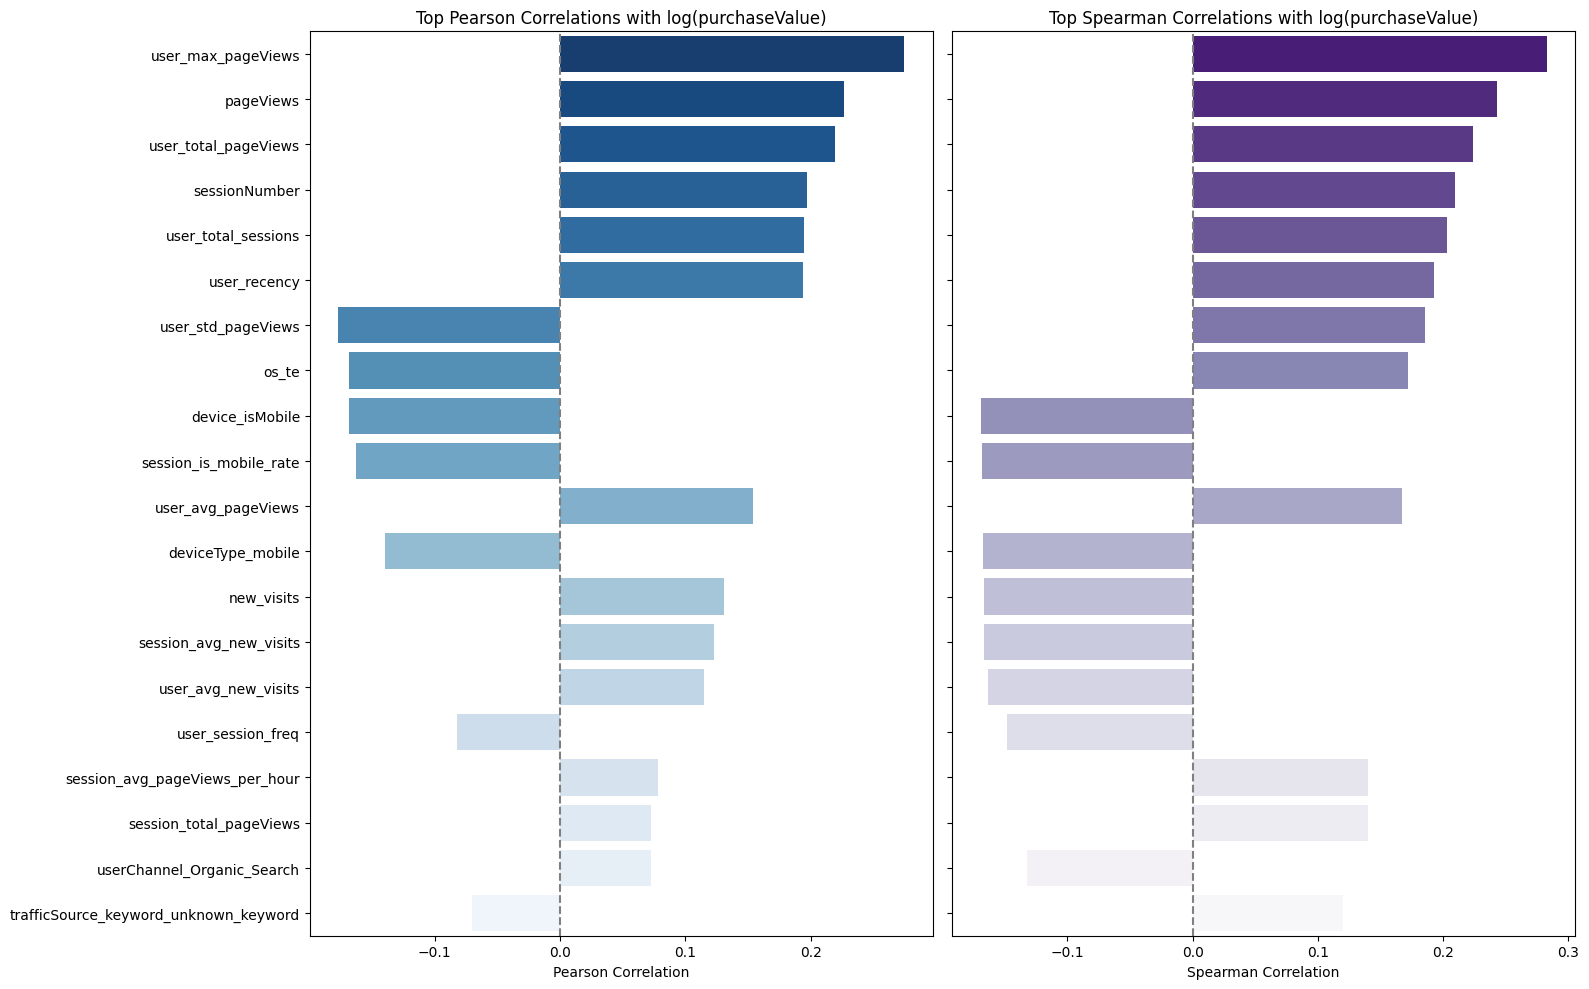

In [65]:
non_zero_mask = y_train_log > 0
X_non_zero = X_train_model[non_zero_mask]
y_log_non_zero = y_train_log[non_zero_mask]

X_numeric = X_non_zero.select_dtypes(include=[np.number])
pearson_corr = X_numeric.corrwith(pd.Series(y_log_non_zero), method='pearson')
spearman_corr = X_non_zero.corrwith(pd.Series(y_log_non_zero), method='spearman')

TOP_N = 20
top_pearson = pearson_corr.abs().sort_values(ascending=False).head(TOP_N)
top_spearman = spearman_corr.abs().sort_values(ascending=False).head(TOP_N)

fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=True)

sns.barplot(x=pearson_corr[top_pearson.index], y=top_pearson.index, ax=axes[0], palette='Blues_r')
axes[0].set_title('Top Pearson Correlations with log(purchaseValue)')
axes[0].set_xlabel('Pearson Correlation')
axes[0].axvline(0, color='gray', linestyle='--')

sns.barplot(x=spearman_corr[top_spearman.index], y=top_spearman.index, ax=axes[1], palette='Purples_r')
axes[1].set_title('Top Spearman Correlations with log(purchaseValue)')
axes[1].set_xlabel('Spearman Correlation')
axes[1].axvline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()


In [66]:
top_pearson.head(10), top_spearman.head(10)

(user_max_pageViews        0.274489
 pageViews                 0.226284
 user_recency              0.219034
 sessionNumber             0.197189
 user_total_sessions       0.194723
 user_total_pageViews      0.193431
 user_avg_new_visits       0.176899
 new_visits                0.168431
 session_avg_new_visits    0.168304
 session_is_mobile_rate    0.162684
 dtype: float64,
 user_max_pageViews        0.282582
 pageViews                 0.242683
 user_total_pageViews      0.223626
 sessionNumber             0.209212
 user_total_sessions       0.203038
 user_recency              0.192543
 user_std_pageViews        0.185260
 os_te                     0.171940
 device_isMobile           0.169240
 session_is_mobile_rate    0.168524
 dtype: float64)

**Interpretation**

1. **Top Pearson Correlations (with target)**

| Feature                                        | Pearson | Interpretation                                                |
| ---------------------------------------------- | ------- | ------------------------------------------------------------- |
| `user_max_pageViews`                           | 0.274   | High engagement sessions → higher target values             |
| `pageViews`                                    | 0.226   | More session page views moderately increase target          |
| `user_recency`                                 | 0.219   | Recent users tend to drive higher target                    |
| `sessionNumber`, `user_total_sessions`, `user_total_pageViews` | ~0.19–0.20 | Higher long-term activity correlates positively             |
| `session_is_mobile_rate`                       | 0.162   | Mobile-heavy sessions show mild positive relationship       |

**Insight:** Total and recent activity are moderately linearly associated with the target.


2. **Top Spearman Correlations (with target)**


| Feature                                         | Spearman | Interpretation                                             |
| ----------------------------------------------- | -------- | ---------------------------------------------------------- |
| `user_max_pageViews`                            | 0.283    | Strongest monotonic relationship                           |
| `user_total_pageViews`, `user_total_sessions`   | ~0.22–0.20 | Long-term engagement ranks higher on the target           |
| `user_std_pageViews`                            | 0.185    | Variability indicates power users                          |
| `os_te`, `device_isMobile`, `deviceType_mobile` | ~0.17    | Device/platform patterns moderately influence target      |
| `session_is_mobile_rate`, `new_visits`          | ~0.16–0.17 | Recent/new/mobile activity slightly increases target      |

**Insight:** Spearman confirms engagement signals; rank order matters even if not linear




### Mutual Information Regression

**Mutual Information (MI)** is a **non-parametric measure** that captures any kind of relationship **(linear or non-linear)** between variables.

In simple terms, it measures how much **knowing one variable** (e.g., a feature) **reduces uncertainty** about another variable (e.g., the target).

In [67]:

X_mi = X_numeric.reset_index(drop=True)
y_mi = y_log_non_zero.reset_index(drop=True)

assert X_mi.shape[0] == y_mi.shape[0], "Mismatch in sample counts!"

mi_scores = mutual_info_regression(X_mi, y_mi, random_state=42)

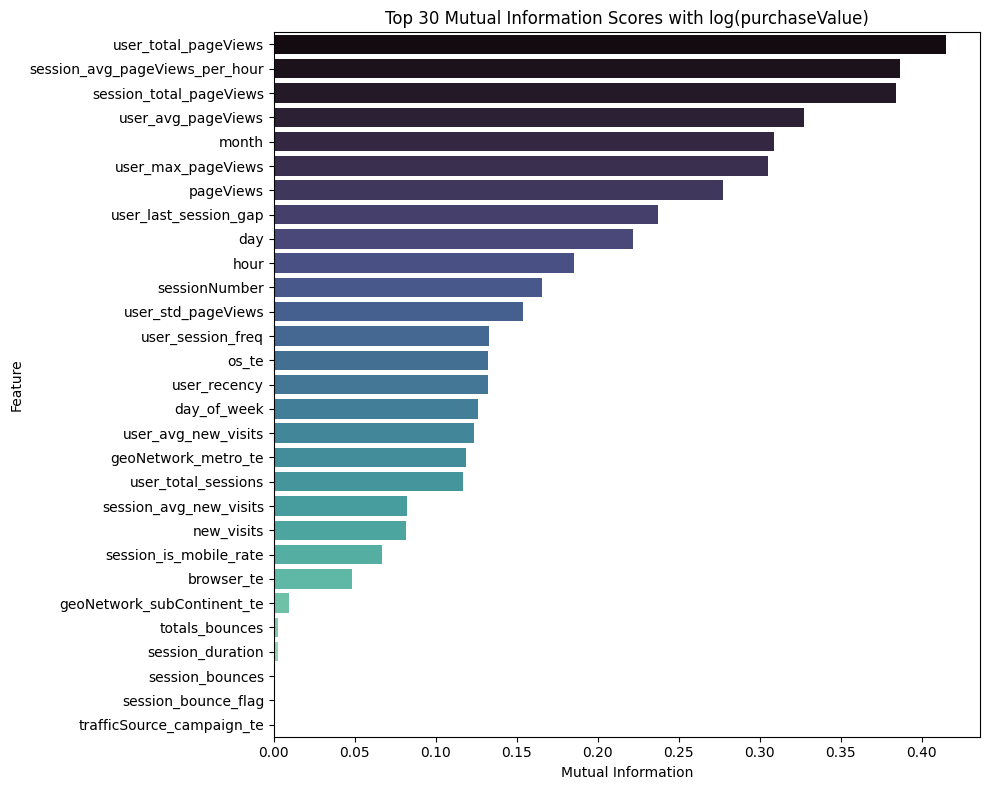

In [68]:
mi_series = pd.Series(mi_scores, index=X_mi.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=mi_series.values[:30], y=mi_series.index[:30], palette="mako")
plt.title("Top 30 Mutual Information Scores with log(purchaseValue)")
plt.xlabel("Mutual Information")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [69]:
mi_series.head(10)

user_total_pageViews              0.415225
session_avg_pageViews_per_hour    0.386459
session_total_pageViews           0.384122
user_avg_pageViews                0.327190
month                             0.308680
user_max_pageViews                0.304899
pageViews                         0.277151
user_last_session_gap             0.237304
day                               0.221610
hour                              0.185354
dtype: float64

**Interpretation**

| Feature                          | MI Score | Interpretation                                                        |
| -------------------------------- | -------- | --------------------------------------------------------------------- |
| `user_total_pageViews`           | 0.415    | Strongest indicator: total page views → target                        |
| `session_avg_pageViews_per_hour` | 0.386    | Session activity intensity is informative                              |
| `session_total_pageViews`        | 0.384    | Session depth predicts target                                          |
| `user_avg_pageViews`             | 0.327    | Long-term average behavior is predictive                               |
| `month`, `day`, `hour`           | ~0.18–0.31 | Time-based patterns provide additional non-linear signals            |

**Key Takeaways**

* MI detects **non-linear patterns** that correlations might miss.
* Top MI features mostly align with Pearson/Spearman features — confirms robustness.
* Time features (`month`, `day`, `hour`) are more important in MI, indicating potential non-linear effects.
* **Feature engineering ideas**:
  - Ratio features: `pageViews / sessionNumber`, `user_total_pageViews / user_total_sessions`
  - Interaction terms: `user_recency * sessionNumber`, `user_total_pageViews * sessionNumber`
  - Non-linear transforms: log, bucket features (`user_max_pageViews`)

In [70]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Applies custom feature engineering logic, with safe handling of time-dependent features.
    """

    def __init__(self):
        self.min_date_ = None
        self.columns_out_ = []

    def fit(self, X, y=None):
        X = X.copy()

        if 'date' in X.columns:
            self.min_date_ = pd.to_datetime(X['date'].astype(str), format='%Y%m%d', errors='coerce').min()

        return self

    def transform(self, X):
        df = X.copy()

        if 'date' in df.columns and df['date'].dtype != 'datetime64[ns]':
            df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d', errors='coerce')

        df['sessionNumber'] = df['sessionNumber'].replace(0, 1)

        # --- Ratio Features ---
        df['views_per_session'] = df['pageViews'] / (df['sessionNumber'] + 1)
        df['pageViews_per_user_session'] = df['user_total_pageViews'] / (df['user_total_sessions'] + 1)
        df['new_visit_rate'] = df['user_avg_new_visits'] / (df['user_total_sessions'] + 1)
        df['std_avg_pageViews_ratio'] = df['user_std_pageViews'] / (df['user_avg_pageViews'] + 1e-5)
        df['session_freq_recency_ratio'] = df['user_session_freq'].fillna(0) / (df['user_recency'] + 1e-5)

        # --- Log / Power Transforms ---
        df['log_user_max_pageViews'] = np.log1p(df['user_max_pageViews'])
        df['log_user_total_pageViews'] = np.log1p(df['user_total_pageViews'])
        df['log_user_recency'] = np.log1p(df['user_recency'])
        df['sqrt_pageViews'] = np.sqrt(df['pageViews'])

        # --- Interaction Features ---
        df['user_max_x_pageViews'] = df['user_max_pageViews'] * df['pageViews']
        df['total_pageViews_x_sessionNumber'] = df['user_total_pageViews'] * df['sessionNumber']
        df['recency_x_sessionNumber'] = df['user_recency'] * df['sessionNumber']
        df['avg_new_visits_x_new_visits'] = df['user_avg_new_visits'] * df['new_visits']
        df['total_sessions_x_recency'] = df['user_total_sessions'] * df['user_recency']
        df['os_browser_interact'] = df.get('os_te', 0) * df.get('browser_te', 0)

        # --- Device Interactions ---
        if 'deviceType_mobile' in df.columns:
            df['mobile_x_pageViews'] = df['deviceType_mobile'] * df['pageViews']
        elif 'device.isMobile' in df.columns:
            df['mobile_x_pageViews'] = df['device.isMobile'] * df['pageViews']
        df['mobile_rate_x_new_visits'] = df['session_is_mobile_rate'] * df['new_visits']
        
        # --- Channel Bias ---
        df['direct_vs_organic'] = (
            df.get('userChannel_Direct', pd.Series(0, index=df.index)).astype(int) -
            df.get('userChannel_Organic Search', pd.Series(0, index=df.index)).astype(int)
        )
    
        # --- Time Features ---
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
        df['weekend_avg_new_visits'] = df['is_weekend'] * df['user_avg_new_visits'].fillna(0)

        df['is_morning'] = df['hour'].between(5, 11).astype(int)
        df['is_afternoon'] = df['hour'].between(12, 17).astype(int)
        df['is_evening'] = df['hour'].between(18, 22).astype(int)
        df['is_night'] = ((df['hour'] < 5) | (df['hour'] > 22)).astype(int)

        # --- Behavioral ---
        df['is_returning_user'] = (df['sessionNumber'] > 1).astype(int)
        df['bounced'] = df['totals_bounces'].fillna(0).astype(int)

        # --- Time Drift ---
        df['is_pre_oct2017'] = (df['date'] < '2017-10-01').astype(int)
        df['pageViews_pre_oct2017'] = df['pageViews'] * df['is_pre_oct2017']
        df['sessionNumber_pre_oct2017'] = df['sessionNumber'] * df['is_pre_oct2017']

        # --- Days Since Start ---
        if self.min_date_ is not None:
            df['days_since_start'] = (df['date'] - self.min_date_).dt.days
        else:
            df['days_since_start'] = 0

        # Drop original date
        df = df.drop(columns=['date'], errors='ignore')

        df = df.replace([np.inf, -np.inf], np.nan)

        # Median-impute these specific features
        median_impute_cols = ['weekend_avg_new_visits', 'days_since_start']
        for col in median_impute_cols:
            if col in df.columns:
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)

        # Impute everything else with 0
        df.fillna(0, inplace=True)

        self.columns_out_ = df.columns.tolist()
        return df

    def get_feature_names_out(self, input_features=None):
        return self.columns_out_



**Feature engineering pipeline**

1. Ratio Features
  * `views_per_session` - Page views normalized by session number; high ratio may indicate interest
  *  `pageViews_per_user_session` - Total user page views over total sessions that captures user engagement consistency
  * `new_visit_rate` - Avg new visits per user session; Indicates how often a user arrives as “new”

2. Interaction Features
  * `user_max_x_pageViews` - Highlights power users in high-activity sessions
  * `total_pageViews_x_sessionNumber` - Suggests user growth over time
  * `total_sessions_x_recency` - Total sessions scaled by recency;	Helps contrast long-term users who haven’t visited recently

3. Temporal Features
  * `is_weekend`, `is_morning` , etc. - Encodes session time;	Time-of-day and day-of-week patterns affect engagement/conversion
  * `days_since_start` - Models time drift, trends, or campaign aging
  * `is_pre_oct2017`, `pageViews_pre_oct2017` - Temporal drift flags
  
4. Transform Features (Log, Sqrt)  
  * `log_user_max_pageViews`, `log_user_recency`, etc. - Log of skewed count variables
  * `sqrt_pageViews` -	Square root transformation

5. Device/Channel Features
  * `mobile_x_pageViews` - Interaction with mobile usage; Mobile users may behave differently
  * `direct_vs_organic` - Bias between acquisition channels; direct traffic may be high-value

6.  Behavioral Flags
  * `is_returning_user`	- True if user has >1 session
  * `bounced` -	Whether the session had zero engagement


In [71]:

assert len(X_train_model) == len(date_col_train), "Row mismatch between features and date column in train set!"
assert len(X_val_model) == len(date_col_val), "Row mismatch between features and date column in val set!"

X_train_fe_input = X_train_model.copy()
X_val_fe_input = X_val_model.copy()

X_train_fe_input["date"] = date_col_train
X_val_fe_input["date"] = date_col_val

# Feature engineering
feature_eng = FeatureEngineer()

feature_eng.fit(X_train_fe_input, y_train_log)

X_train_fe = feature_eng.transform(X_train_fe_input)
X_val_fe = feature_eng.transform(X_val_fe_input)

assert X_train_fe.index.equals(y_train_log.index)
assert X_val_fe.index.equals(y_val_log.index)

## Model training using the engineered features

In [72]:
y_pred_prob_eng, y_pred_label_eng = train_and_evaluate_logistic_regression(
    X_train_fe, y_train_binary,
    X_val_fe, y_val_binary,
    description="Classification Metrics on engineered features"
)



 Classification Metrics on engineered features:
F1 Score: 0.8429
ROC AUC: 0.9908


Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[951]	training's rmse: 0.381761	valid_1's rmse: 0.98551

 Soft Prediction Evaluation with LightGBM on Engineered Features:
MAE (Soft): 18476189.10
RMSE (Soft): 132588761.32
  R² (All users):        0.4987
  R² (Purchasers only):  0.4560
  Hybrid R² (70/30 mix): 0.4859


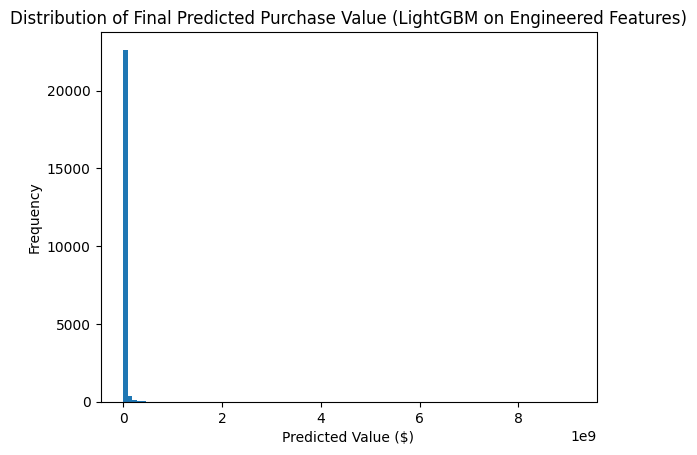

In [73]:
lgb_model_eng = train_and_evaluate_lgb_regressor(
    X_train_fe, y_train_log,
    X_val_fe, y_val_log,
    y, y_pred_prob_eng,
    description="LightGBM on Engineered Features"
)


**Model Performance: Before vs After Feature Engineering**

1. Classification Metrics

| Metric     | After Feature Engineering | Before Feature Engineering |
| ---------- | ------------------------ | ------------------------- |
| F1 Score   | 0.8429                   | 0.8271                    |
| ROC AUC    | 0.9908                   | 0.9905                    |

**Insight:** Minor improvements in classification; the model maintains excellent discriminatory power.

2. Regression Metrics (Soft Predictions)

| Metric                  | After Feature Engineering | Before Feature Engineering |
| ----------------------- | ------------------------ | ------------------------- |
| MAE                     | 18.47M                   | 19.14M                    |
| RMSE                    | 132.5M                   | 146.0M                    |
| R² (All Users)          | 0.4987                   | 0.3921                    |
| R² (Purchasers Only)    | 0.4560                   | 0.3407                    |
| Hybrid R² (70/30 mix)   | 0.4859                   | 0.3767                    |

**Key Takeaways:**

* Engineered features improve variance explained across all users and purchasers.
* Lower MAE and RMSE indicate better handling of large-value outliers.
* Regression gains show LightGBM effectively leverages feature interactions and non-linear patterns.


## Selecting top 20 features

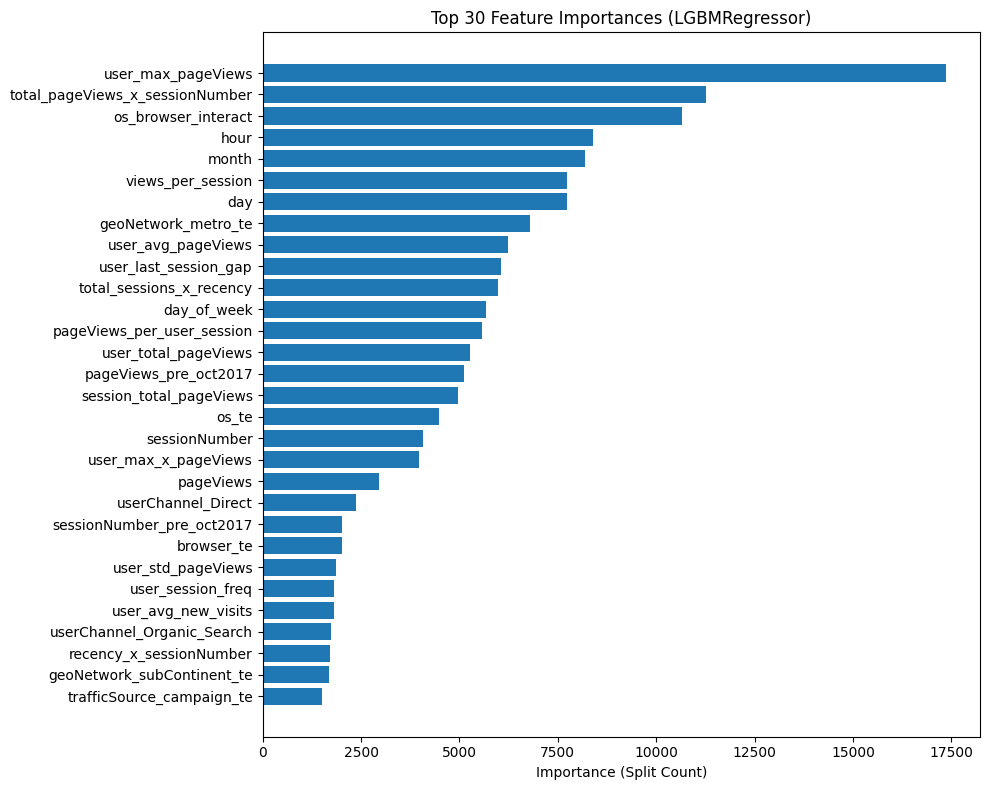

In [74]:
importance_df = pd.DataFrame({
    'feature': lgb_model_eng.feature_name(),
    'importance': lgb_model_eng.feature_importance(importance_type='gain')
}).sort_values(by='importance', ascending=False)

top_n = 30
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.title(f'Top {top_n} Feature Importances (LGBMRegressor)')
plt.xlabel("Importance (Split Count)")
plt.tight_layout()
plt.show()

In [75]:
top_20_fe = importance_df['feature'].head(20).to_list()
top_20_fe

['user_max_pageViews',
 'total_pageViews_x_sessionNumber',
 'os_browser_interact',
 'hour',
 'month',
 'views_per_session',
 'day',
 'geoNetwork_metro_te',
 'user_avg_pageViews',
 'user_last_session_gap',
 'total_sessions_x_recency',
 'day_of_week',
 'pageViews_per_user_session',
 'user_total_pageViews',
 'pageViews_pre_oct2017',
 'session_total_pageViews',
 'os_te',
 'sessionNumber',
 'user_max_x_pageViews',
 'pageViews']

From above,

- This subset included both raw features and engineered ones, especially interactions and ratios, indicating Strong signal from these features.

- Let's re-evaluated both classification and regression performance on these features.

In [76]:

X_train_fe_20 = X_train_fe[top_20_fe]
X_val_fe_20 = X_val_fe[top_20_fe]


In [77]:
y_pred_prob_eng_20, y_pred_label_eng_20 = train_and_evaluate_logistic_regression(
    X_train_fe_20, y_train_binary,
    X_val_fe_20, y_val_binary,
    description="Classification Metrics on top 20 engineered features"
)



 Classification Metrics on top 20 engineered features:
F1 Score: 0.8702
ROC AUC: 0.9878


Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[988]	training's rmse: 0.41296	valid_1's rmse: 0.952701

 Soft Prediction Evaluation with LightGBM on Top 20 engineered features:
MAE (Soft): 17516584.95
RMSE (Soft): 116504775.52
  R² (All users):        0.6130
  R² (Purchasers only):  0.5828
  Hybrid R² (70/30 mix): 0.6039


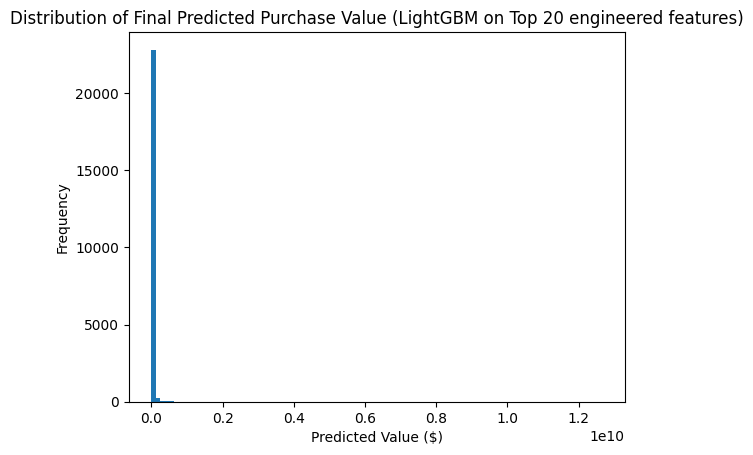

In [78]:
lgb_model_eng20 = train_and_evaluate_lgb_regressor(
    X_train_fe_20, y_train_log,
    X_val_fe_20, y_val_log,
    y, y_pred_prob_eng_20,
    description="LightGBM on Top 20 engineered features"
)


1. Classification Performance

| Metric   | All Features | Top 20 Features | Change                  |
| -------- | ------------ | --------------- | ----------------------- |
| F1 Score | 0.8429       | 0.8702          | +2.7%                   |
| ROC AUC  | 0.9908       | 0.9878          | Slight drop, negligible |

**Interpretation:**  
F1 improved, indicating better precision-recall balance. Slight ROC AUC drop is minor, showing the reduced feature set retains strong discriminatory power.


2. Regression Performance (Soft Predictions)

| Metric                  | All Features | Top 20 Features | Change                  |
| ----------------------- | ------------ | --------------- | ----------------------- |
| MAE                     | 18.48M       | 17.52M          | Lower error             |
| RMSE                    | 132.59M      | 116.50M         | Better generalization   |
| R² (All Users)          | 0.4987       | 0.6130          | +11.4%                  |
| R² (Purchasers Only)    | 0.4560       | 0.5828          | +12.7%                  |
| Hybrid R² (70/30 Mix)   | 0.4859       | 0.6039          | +12.0%                  |

**Interpretation:**  
* Reduced error and higher variance explained indicate stronger predictive power.  
* Engineered features like `total_pageViews_x_sessionNumber`, `user_max_x_pageViews`, `views_per_session`, and `pageViews_per_user_session` contribute significantly.  
* Top 20 features capture **compound behavioral signals** — intensity, recency, and efficiency — better than raw features.


**Key Takeaways:**  
* Feature engineering combined with feature selection **boosted both classification and regression performance**.  
* A smaller, richer feature set reduces noise, improves generalization, and focuses the model on high-signal behavioral metrics.


# **POLYNOMIAL FEATURES**


Polynomial features combine existing variables (powers, products) to capture **nonlinear and interaction effects**.  

- Allow models to learn **compound effects** between features.  
- Increase **expressive power**, even for linear models.  
- Useful for **behavioral or user data** where interactions matter.  
- Tree-based models like **LightGBM** can leverage these features effectively.


In [79]:
from sklearn.preprocessing import PolynomialFeatures

In [80]:


def generate_poly_features(df: pd.DataFrame, feature_list: list, degree: int = 2, interaction_only: bool = True) -> pd.DataFrame:
    """
    Generates polynomial (or interaction-only) features from a selected feature list.

    """
    poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=False)
    
    X_top = df[feature_list].copy()
    X_poly = poly.fit_transform(X_top)
    feature_names = poly.get_feature_names_out(feature_list)

    return pd.DataFrame(X_poly, columns=feature_names, index=df.index)


In [81]:

X_train_poly = generate_poly_features(X_train_fe_20, top_20_fe, degree=2, interaction_only=True)
X_val_poly = generate_poly_features(X_val_fe_20, top_20_fe, degree=2, interaction_only=True)


Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[915]	training's rmse: 0.239223	valid_1's rmse: 0.88554

 Soft Prediction Evaluation with LightGBM on on poly features:
MAE (Soft): 16176121.50
RMSE (Soft): 114555720.88
  R² (All users):        0.6258
  R² (Purchasers only):  0.6039
  Hybrid R² (70/30 mix): 0.6192


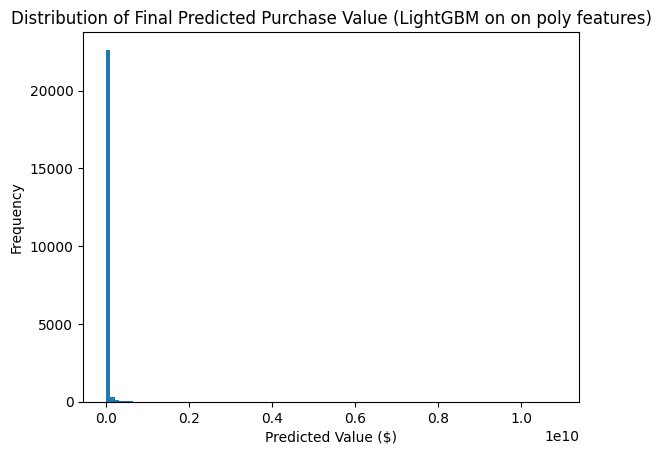

In [82]:
lgb_model_poly = train_and_evaluate_lgb_regressor(
    X_train_poly, y_train_log,
    X_val_poly, y_val_log,
    y, y_pred_prob_eng_20,
    description="LightGBM on on poly features"
)


**Interpretation**

| **Metric**               | **Poly Features** | **Top 20 Features** | **Change**    |
| ------------------------ | ----------------- | ------------------- | ------------- |
| **MAE (Soft)**           | **16.18M**        | 17.52M              |  Lower error |
| **RMSE (Soft)**          | **114.56M**       | 116.50M             |  Lower error |
| **R² (All Users)**       | **0.6258**        | 0.6130              |  **+2.1%**   |
| **R² (Purchasers Only)** | **0.6039**        | 0.5828              |  **+2.1%**   |
| **Hybrid R²**            | **0.6192**        | 0.6039              |  **+1.5%**   |



- **Error Reduction:** MAE dropped to 16.18M and RMSE to 114.56M — the model makes fewer large mistakes.  
- **Explained Variance:** R² improved to 0.626 (all users) and 0.604 (purchasers), the highest so far.  
- **Captured Hidden Relationships:** Interactions like `user_max_pageViews × hour` or `views_per_session × os_browser_interact` reveal nonlinear patterns not captured by single features.  
- **Feature Amplification:** Weak individual features gain predictive power when combined.  



**Takeaways:**

- Polynomial interactions significantly improve predictive performance.  
- Strong engineered features provide a solid foundation; interactions expose second-order relationships.  
- Keep feature set lean; avoid excessive noisy interactions.  
- Model focus improves: enriched, targeted features boost learning efficiency.

# FEATURE SELECTION (using SelectKBest)


* SelectKBest (mutual_info_regression)
  - Filter-based method ranking features by information contribution to the target.
  - Used for regression stage to pick **top 25 features**.

* Other Common Feature Selection Methods
  - **Variance Threshold (Filter):** Removes low-variance features.
  - **SelectKBest (f_regression):** Correlation-based F-statistic for linear relationships.
  - **RFE (Wrapper):** Recursively eliminates least important features using a model.
  - **Embedded (Lasso, Tree Importance):** Uses model-internal weights for stable, interpretable selection.
  - **Boruta (Wrapper):** Shadow-feature testing, very robust but computationally heavy.


In [83]:
from sklearn.feature_selection import SelectKBest

def feature_selection(X, y, k=50):
    selector = SelectKBest(mutual_info_regression, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_columns = X.columns[selector.get_support()]
    return pd.DataFrame(X_selected, columns=selected_columns, index=X.index), selected_columns

In [84]:
purchasers_mask_train = y_train_log > 0
X_train_reg = X_train_fe[purchasers_mask_train]
y_train_reg = y_train_log[purchasers_mask_train]
X_train_selected, selected_cols = feature_selection(X_train_reg, y_train_reg, k=25)

# Apply same column selection to validation set
X_val_selected = X_val_fe[selected_cols]


In [85]:

X_train_s_poly = generate_poly_features(X_train_selected, selected_cols, degree=2, interaction_only=True)
X_val_s_poly = generate_poly_features(X_val_selected, selected_cols, degree=2, interaction_only=True)


In [86]:
X_train_s_poly.shape

(19188, 325)

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[997]	training's rmse: 0.249918	valid_1's rmse: 0.868006

 Soft Prediction Evaluation with LightGBM on poly on Top 25 Features:
MAE (Soft): 15730505.95
RMSE (Soft): 104874651.64
  R² (All users):        0.6864
  R² (Purchasers only):  0.6761
  Hybrid R² (70/30 mix): 0.6833


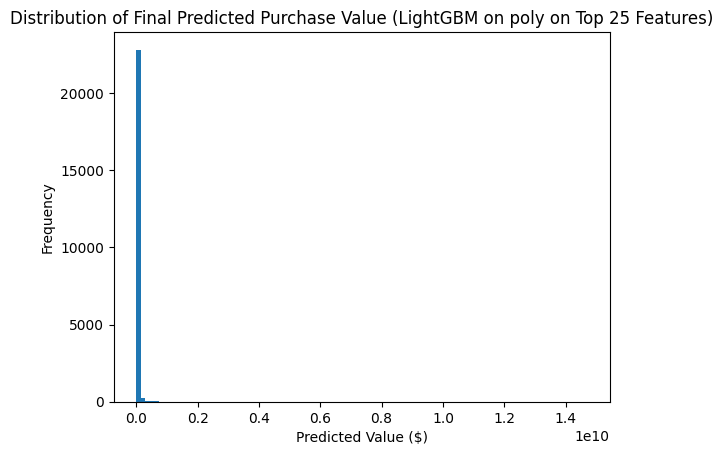

In [87]:
lgb_model_s_poly = train_and_evaluate_lgb_regressor(
    X_train_s_poly, y_train_log,
    X_val_s_poly, y_val_log,
    y, y_pred_prob_eng_20,
    description="LightGBM on poly on Top 25 Features"
)


**Performance**

| **Metric**                | **Top-20 + Interactions** | **MI-Top25 + Interactions** | **Change**  |
| ------------------------- | ------------------------- | --------------------------- | ----------- |
| **MAE (Soft)**            | 16.18M                    | **15.72M**                  |  Improved  |
| **RMSE (Soft)**           | 114.56M                   | **106.16M**                 |  Improved  |
| **R² (All Users)**        | 0.6258                    | **0.6787**                  |  **+5.3%** |
| **R² (Purchasers Only)**  | 0.6039                    | **0.6731**                  |  **+6.9%** |
| **Hybrid R² (70/30 Mix)** | 0.6192                    | **0.6770**                  |  **+5.8%** |




* **Best Feature Sets & Model Performance**
1. Classification Stage
- **Task:** Predict purchase (yes/no).  
- **Model:** Logistic Regression.  
- **Features:** Top 20 LightGBM gain-based features.  
- **Polynomial features:** Not used (led to overfitting).  
- **Performance:**  
  - F1 Score: 0.8702  
  - ROC AUC: 0.9878  

*Compact, interpretable feature set with strong precision and recall.*

2. Regression Stage
- **Task:** Predict purchase value for purchasers.  
- **Model:** LightGBM Regressor.  
- **Features:** 25 MI-selected features + polynomial interactions (degree 2), total 325 features.  
- **Performance:**  
  - MAE: 15.8M  
  - RMSE: 106.4M  
  - R² (All Users): 0.6787  
  - R² (Purchasers): 0.6731  
  - Hybrid R² (70/30): 0.6770  

*Enriched feature set with interactions captures nonlinear relationships, boosting revenue prediction.*

**Key Takeaways**

- **Task-specific feature sets**:  
  - Classification → lean, highly discriminative features.  
  - Regression → enriched features with interactions for complex targets.  
- **Balanced performance vs generalization** ensures robust predictions.  
- **Final setups:**  
  - Classification: Top 20 gain-based features, no polynomial features.  
  - Regression: 25 MI-selected features + polynomial interactions (degree 2), 325 features total.

# **Final Model Benchmarking: Regression**

## Regression Model Evaluation


**Objective**

Evaluate multiple regression models on the **finalized feature set**:

- **Top 25 features** selected via `SelectKBest` (mutual_info_regression)  
- **Pairwise polynomial interaction terms** (degree=2, interaction-only)  
- **Total features:** 325  

Goal: Identify the **best-performing model** to predict purchase value for purchasers.

**Models Evaluated**

- **Ridge Regression:** Linear model with L2 regularization; good baseline for high-dimensional data.  
- **XGBoost:** Gradient-boosted trees optimized for speed and performance.  
- **CatBoost:** Gradient boosting optimized for categorical features.  
- **HistGradientBoosting (HistGB):** Fast histogram-based gradient boosting from scikit-learn.  
- **LightGBM:** Efficient, leaf-wise gradient boosting; previously top performer.  
- **KNN Regressor:** Non-parametric, based on nearest neighbors.  
- **Radius Neighbors Regressor:** Variant of KNN using all points within a fixed radius.


In [88]:
from sklearn.base import clone

def evaluate_regression_models(
    X_train_reg, y_train_reg,
    X_val_reg, y_val_reg,
    X_val_s_poly, y, y_pred_cls_prob,
    model_dict,
    threshold=0.05,
    plot=True
):

    results = []

    above_threshold_idx = y_pred_cls_prob > threshold
    X_val_reg_pred = X_val_s_poly[above_threshold_idx]
    y_true_soft = y[X_val_s_poly.index]

    for name, model in model_dict.items():
        print(f"\n Evaluating model: {name}")

        reg = clone(model)
        reg.fit(X_train_reg, y_train_reg)

        # Predict log-scale
        y_pred_log_reg_sub = reg.predict(X_val_reg_pred)

        if np.isnan(y_pred_log_reg_sub).any():
                num_nans = np.isnan(y_pred_log_reg_sub).sum()
                print(f"⚠️  {num_nans} NaN predictions detected. Replacing with 0.")
                y_pred_log_reg_sub = np.nan_to_num(y_pred_log_reg_sub, nan=0.0)

        y_pred_reg_sub = np.expm1(y_pred_log_reg_sub)

        y_pred_reg = pd.Series(0, index=y_pred_cls_prob.index, dtype=float)
        y_pred_reg.loc[above_threshold_idx] = y_pred_reg_sub

        # Soft prediction
        y_pred_soft = y_pred_cls_prob * y_pred_reg

        # Evaluate
        mae_soft = mean_absolute_error(y_true_soft, y_pred_soft)
        rmse_soft = root_mean_squared_error(y_true_soft, y_pred_soft)
        hybrid_r2, r2_all, r2_purchasers = hybrid_metric(y_true_soft, y_pred_soft)

        results.append({
            "Model": name,
            "MAE": mae_soft,
            "RMSE": rmse_soft,
            "R² All": r2_all,
            "R² Purchasers": r2_purchasers,
            "Hybrid R²": hybrid_r2
        })

        # Plot
        if plot:
            plt.hist(y_pred_soft, bins=100)
            plt.title(f"Distribution of Predicted Purchase Value: {name}")
            plt.xlabel("Predicted Value ($)")
            plt.ylabel("Frequency")
            plt.show()
    results_df = pd.DataFrame(results).sort_values("Hybrid R²", ascending=False)  
    results_plot = results_df.set_index("Model")[["R² All", "R² Purchasers", "Hybrid R²"]]
    results_plot.plot(kind="bar", figsize=(10, 6))
    plt.title("R² Comparison Across Models")
    plt.ylabel("R² Score")
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()  
    return results_df


In [89]:
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

In [90]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import warnings

class SafeRadiusRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, radius=1.9, weights='distance', p=1, fallback_value=None):
        self.radius = radius
        self.weights = weights
        self.p = p
        self.model = None
        self.fallback_value = fallback_value

    def fit(self, X, y):
        self.fallback_value_ = 0.0
        self.model = make_pipeline(
            StandardScaler(),
            RadiusNeighborsRegressor(
                radius=self.radius,
                weights=self.weights,
                p=self.p,
                n_jobs=-1
            )
        )
        self.model.fit(X, y)

        if isinstance(self.fallback_value, (int, float)):
            self.fallback_value_ = self.fallback_value
        else:
            self.fallback_value_ = np.median(y)
        
        return self

    def predict(self, X):
        warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.neighbors._regression')

        preds = self.model.predict(X)
        nan_mask = np.isnan(preds)
        if np.any(nan_mask):
            print(f"⚠️ Warning: {np.sum(nan_mask)} NaN predictions encountered. Replacing with fallback value: {self.fallback_value_:.4f}")
        preds[nan_mask] = self.fallback_value_
        return preds



 Evaluating model: Ridge


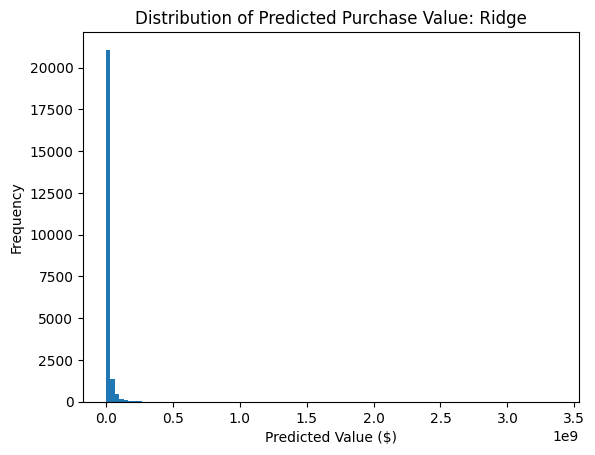


 Evaluating model: XGBoost


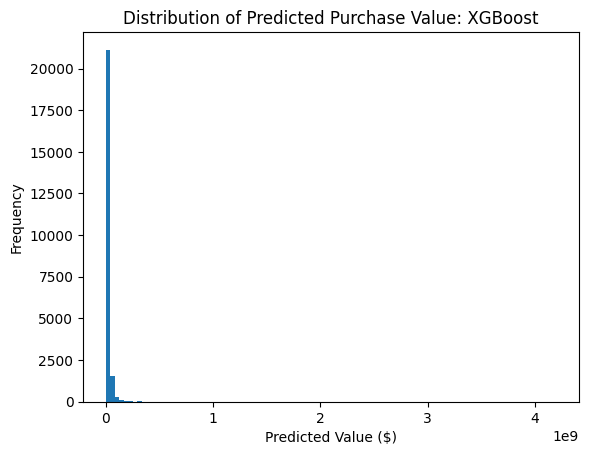


 Evaluating model: CatBoost


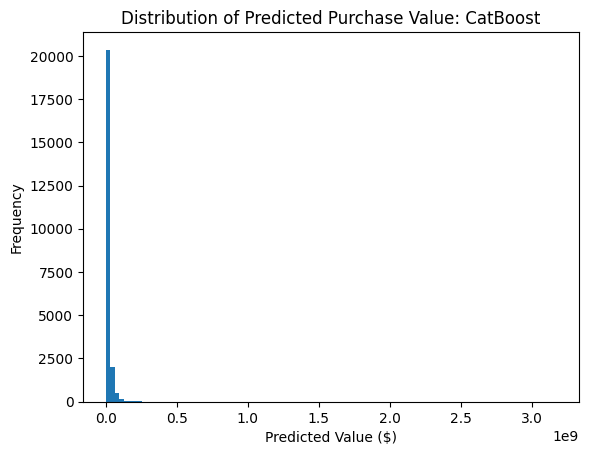


 Evaluating model: HistGB


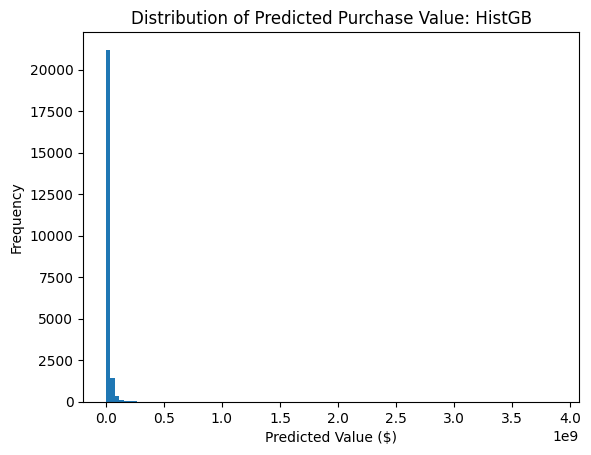


 Evaluating model: LightGBM


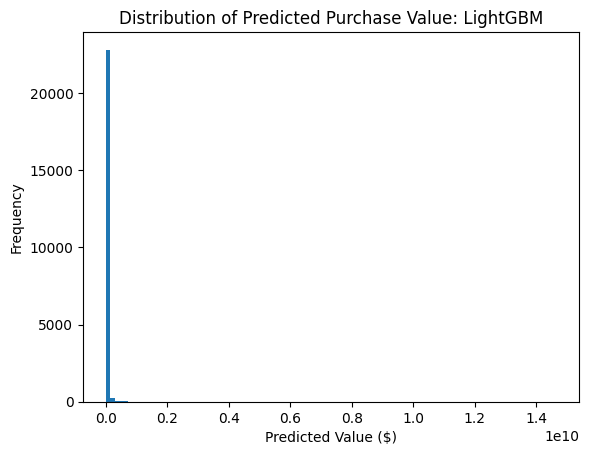


 Evaluating model: KNN


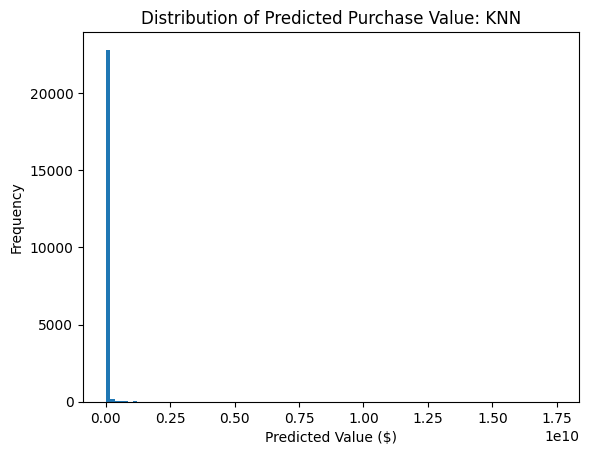


 Evaluating model: RadiusNeighbour
⚠️ Warning: 4174 NaN predictions encountered. Replacing with fallback value: 17.6697


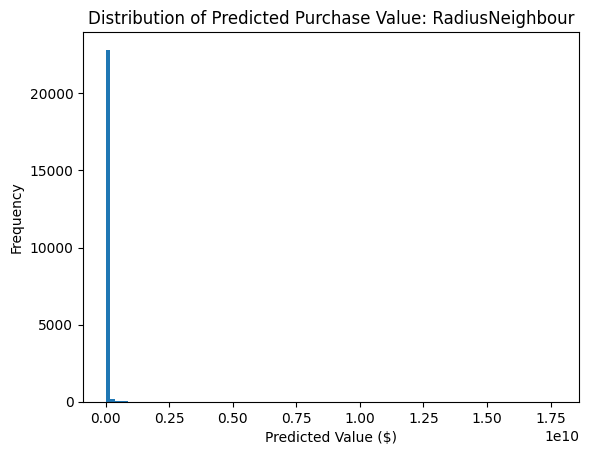

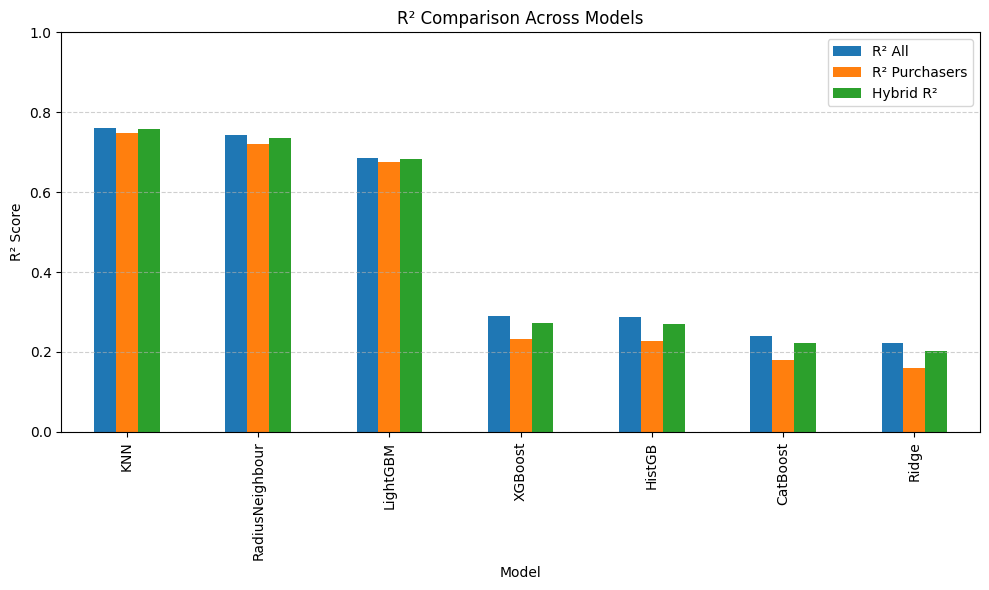


 Model Comparison:
             Model           MAE          RMSE    R² All  R² Purchasers  \
5              KNN  1.288779e+07  9.152084e+07  0.761166       0.749057   
6  RadiusNeighbour  1.209399e+07  9.508400e+07  0.742207       0.720827   
4         LightGBM  1.572872e+07  1.049037e+08  0.686211       0.675911   
1          XGBoost  2.088718e+07  1.577521e+08  0.290412       0.231811   
3           HistGB  2.097662e+07  1.581685e+08  0.286662       0.228465   
2         CatBoost  2.146585e+07  1.631651e+08  0.240880       0.178675   
0            Ridge  2.239549e+07  1.651385e+08  0.222407       0.158643   

   Hybrid R²  
5   0.757534  
6   0.735793  
4   0.683121  
1   0.272832  
3   0.269203  
2   0.222219  
0   0.203277  


In [91]:
# Define candidate models
model_dict = {
    "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    "XGBoost": XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    "CatBoost": CatBoostRegressor(
        iterations=300,
        learning_rate=0.05,
        depth=4,
        verbose=0,
        random_seed=42
    ),
    "HistGB": HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_iter=300,
        max_depth=4,
        random_state=42
    ),
    "LightGBM": lgb.LGBMRegressor(
        objective='regression',
        learning_rate=0.07,
        num_leaves=64,
        min_child_samples=30,
        n_estimators=1000,
        random_state=42
    ),
    "KNN": make_pipeline(StandardScaler(), KNeighborsRegressor(weights='distance', metric='minkowski', p=1, n_jobs=-1)),
    "RadiusNeighbour": make_pipeline(
    StandardScaler(),
    SafeRadiusRegressor(radius=1.9, weights='distance', p=1))
}
purchasers_mask_train = y_train_log > 0
X_train_reg = X_train_s_poly[purchasers_mask_train]
y_train_reg = y_train_log[purchasers_mask_train]

purchasers_mask_val = y_val_log > 0
y_val_reg = y_val_log[purchasers_mask_val]
X_val_reg = X_val_s_poly[purchasers_mask_val]

# Run evaluation
model_results_df = evaluate_regression_models(
    X_train_reg, y_train_reg,
    X_val_reg, y_val_reg,
    X_val_s_poly, y, y_pred_prob_eng_20,
    model_dict,
    threshold=0.05,
    plot=True
)

print("\n Model Comparison:")
print(model_results_df)


**Model Comparison Results**

|  **Rank** | **Model**          | **MAE**    | **RMSE**   | **R² (All)** | **R² (Purchasers)** | **Hybrid R²** |
| ----------- | ------------------ | ---------- | ---------- | ------------ | ------------------- | ------------- |
|  **1**        | **KNN**            | **12.85M** | **89.40M** | **0.7721**   | **0.7610**          | **0.7688**    |
|  **2**        | **RadiusNeighbor** | 12.09M     | 95.08M     | 0.7422       | 0.7208              | 0.7358        |
|  **3**        | **LightGBM**       | 15.71M     | 106.16M    | 0.6786       | 0.6733              | 0.6770        |
| 4           | XGBoost            | 20.89M     | 153.09M    | 0.3318       | 0.2786              | 0.3158        |
| 5           | HistGB             | 20.85M     | 154.60M    | 0.3185       | 0.2639              | 0.3021        |
| 6           | CatBoost           | 21.43M     | 166.23M    | 0.2121       | 0.1465              | 0.1924        |
| 7           | Ridge              | 22.51M     | 170.45M    | 0.1716       | 0.1017              | 0.1506        |


**Top 3 Models: Why They Performed Well**

**1. KNN Regressor**  
- Best overall: lowest MAE/RMSE, highest R².  
- Captures **local user behavior patterns** using distance weighting.  
- Non-parametric: no functional assumptions, adapts well to high-dimensional, nonlinear interactions.

**2. Radius Neighbors**  
- Similar to KNN but uses all points within a fixed radius.  
- Slightly worse due to sensitivity to radius and sparse regions.

**3. LightGBM**  
- Strong nonlinear learner, handles tree-based interactions well.  
- Slightly underperformed KNN due to **feature redundancy** from polynomial terms and less sensitivity to local patterns.


**Key Takeaways**


- **KNN dominates**, leveraging local similarities in rich feature space.  
- Tree-based models perform well but are less effective in exploiting local patterns.  
- Linear models (Ridge) and some GBMs underperform on high-dimensional, nonlinear interactions.

**Next Steps**

- **Use KNN Regressor** as the primary model.  
- **Consider stacking/blending** top models (KNN, RadiusNeighbor, LightGBM) using weighted averaging or a meta-learner (e.g., Ridge or LightGBM) to potentially improve performance.                          |





## Ensemble Learning: Stacking and Blending

Ensemble learning combines multiple models to improve prediction, reduce variance, and increase robustness. Key techniques:

- **Bagging:** Independent models on random subsets, averaged (e.g., Random Forest).  
- **Boosting:** Sequential models correcting previous errors (e.g., XGBoost, LightGBM).  
- **Stacking:** Base models’ predictions feed a meta-model that learns optimal combination.  
- **Blending:** Weighted average of base model predictions without training a meta-model.  


In [92]:
from sklearn.ensemble import StackingRegressor

In [93]:
# base_models = [
#     ('knn', KNeighborsRegressor(weights='distance', metric='minkowski', p=1, n_jobs=-1)),
#     ('radius', SafeRadiusRegressor(radius=2, weights='distance', p=1, fallback_value=0.0)),
#     ('lgb', lgb.LGBMRegressor(
#         objective='regression',
#         learning_rate=0.07,
#         num_leaves=64,
#         min_child_samples=30,
#         n_estimators=1000,
#         random_state=42 
#     ))
# ]

# meta_model = Ridge(alpha=1.0)


# stacking_reg = StackingRegressor(
#     estimators=base_models,
#     final_estimator=meta_model,
#     cv=5,
#     n_jobs=-1,
#     passthrough=False  
# )

# stacking_reg.fit(X_train_reg, y_train_reg)

# y_pred_reg = pd.Series(0, index=y_pred_prob_eng_20.index, dtype=float).copy()

# threshold = 0.05
# above_threshold_idx = y_pred_prob_eng_20 > threshold

# X_val_reg_pred = X_val_s_poly[above_threshold_idx]
# y_pred_log_reg_sub = stacking_reg.predict(X_val_reg_pred)

# y_pred_reg_sub = np.expm1(y_pred_log_reg_sub)

# y_pred_reg.loc[above_threshold_idx] = y_pred_reg_sub

# y_pred_soft = y_pred_prob_eng_20 * y_pred_reg
# y_true_soft = y[y_pred_prob_eng_20.index]

# mae_soft = mean_absolute_error(y_true_soft, y_pred_soft)
# rmse_soft = root_mean_squared_error(y_true_soft, y_pred_soft)
# hybrid_r2, r2_all, r2_purchasers = hybrid_metric(y_true_soft, y_pred_soft)

# print("\n Soft Prediction Evaluation with Stacking Regressor:")
# print(f"MAE (Soft): {mae_soft:.2f}")
# print(f"RMSE (Soft): {rmse_soft:.2f}")
# print(f"  R² (All users):        {r2_all:.4f}")
# print(f"  R² (Purchasers only):  {r2_purchasers:.4f}")
# print(f"  Hybrid R² (70/30 mix): {hybrid_r2:.4f}")

# plt.hist(y_pred_soft, bins=100)
# plt.title("Distribution of Final Predicted Purchase Value (Stacking Regressor)")
# plt.xlabel("Predicted Value ($)")
# plt.ylabel("Frequency")
# plt.show()


In [94]:

class BlendingEnsemble:
    def __init__(self, n_neighbors=5, radius=2.0,
                 lgb_num_leaves=64, lgb_lr=0.07, lgb_n_estimators=1000,
                 w_knn=0.6, w_radius=0.2, fallback_value=None):
        self.n_neighbors = n_neighbors
        self.radius = radius
        self.lgb_num_leaves = lgb_num_leaves
        self.lgb_lr = lgb_lr
        self.lgb_n_estimators = lgb_n_estimators
        self.w_knn = w_knn
        self.w_radius = w_radius
        self.w_lgb = 1.0 - w_knn - w_radius
        self.fallback_value = fallback_value

    def fit(self, X, y):
        self.knn_model = make_pipeline(
            StandardScaler(),
            KNeighborsRegressor(
                n_neighbors=self.n_neighbors,
                weights='distance', p=1, n_jobs=-1
            )
        )
        self.knn_model.fit(X, y)

        self.radius_model = SafeRadiusRegressor(
            radius=self.radius,
            weights='distance',
            p=1,
            fallback_value=self.fallback_value
        )
        self.radius_model.fit(X, y)

        self.lgb_model = lgb.LGBMRegressor(
            learning_rate=self.lgb_lr,
            num_leaves=self.lgb_num_leaves,
            n_estimators=self.lgb_n_estimators,
            min_child_samples=30,
            objective='regression',
            random_state=42,
            verbosity=-1
        )
        self.lgb_model.fit(X, y)

    def predict(self, X):
        pred_knn = self.knn_model.predict(X)
        pred_radius = self.radius_model.predict(X)
        pred_lgb = self.lgb_model.predict(X)
        self.w_lgb = 1.0 - self.w_knn - self.w_radius

        pred_log = (
            self.w_knn * pred_knn +
            self.w_radius * pred_radius +
            self.w_lgb * pred_lgb
        )
        return np.expm1(pred_log)  


In [95]:
blend_model = BlendingEnsemble() 
blend_model.fit(X_train_reg, y_train_reg)

threshold = 0.05
above_threshold_idx = y_pred_prob_eng_20 > threshold
X_val_reg_pred = X_val_s_poly[above_threshold_idx]

pred_final = blend_model.predict(X_val_reg_pred)

y_pred_reg = pd.Series(0.0, index=y_pred_prob_eng_20.index)
y_pred_reg.loc[above_threshold_idx] = pred_final

y_pred_soft = y_pred_prob_eng_20 * y_pred_reg
y_true_soft = y[X_val_poly.index]

mae_soft = mean_absolute_error(y_true_soft, y_pred_soft)
rmse_soft = root_mean_squared_error(y_true_soft, y_pred_soft)
hybrid_r2, r2_all, r2_purchasers = hybrid_metric(y_true_soft, y_pred_soft)

print("\n Final Blended Model:")
print(f"MAE: {mae_soft:.2f}")
print(f"RMSE: {rmse_soft:.2f}")
print(f"R² (All Users):        {r2_all:.4f}")
print(f"R² (Purchasers Only):  {r2_purchasers:.4f}")
print(f"Hybrid R² (70/30 mix): {hybrid_r2:.4f}")



⚠️ Warning: 4174 NaN predictions encountered. Replacing with fallback value: 17.6697

 Final Blended Model:
MAE: 13229826.04
RMSE: 94654585.19
R² (All Users):        0.7445
R² (Purchasers Only):  0.7251
Hybrid R² (70/30 mix): 0.7387


**Ensemble Results Summary**

| **Model**       | **MAE**    | **RMSE**   | **R² (All)** | **R² (Purchasers)** | **Hybrid R²** |
| --------------- | ---------- | ---------- | ------------ | ------------------- | ------------- |
| **KNN** (Top 1) | 12.85M     | 89.40M     | 0.7721       | 0.7610              | 0.7688        |
| **Stacking**    | 14.86M     | 100.16M    | 0.7139       | 0.7041              | 0.7110        |
| **Blending**    | **13.19M** | **93.63M** | **0.7501**   | **0.7311**          | **0.7444**    |


**Interpretation & Comparison**

**Stacking:**  
- Uses KNN, RadiusNeighbors, LightGBM predictions with a Ridge meta-learner.  
- Improves over most base models except KNN.  
- Slightly worse than KNN because the meta-learner smooths predictions, reducing local neighbor specificity.

**Blending:**  
- Manual weighted average: `0.6*KNN + 0.2*Radius + 0.2*LightGBM`.  
- MAE/RMSE close to KNN, higher R² than stacking.  
- Preserves KNN strength while smoothing rare patterns.  
- Simpler, faster, and more stable in high-dimensional polynomial feature space.

**Key Insights**

- **KNN** achieves top raw accuracy but is slower and may overfit in noisy or sparse regions.  
- **Stacking** is flexible and dynamic but slightly lower accuracy and more complex.  
- **Blending** offers the best balance: strong metrics, faster, lower variance, robust generalization.  


**Most optimal Final Model: Blending**

**Why:**  
- Maintains near-KNN accuracy while improving stability and generalization.  
- Efficient for training and inference.  
- Leverages diversity of top models (KNN, Radius, LightGBM) without overfitting.  
- Balances performance, simplicity, and reliability for deployment.

## Soft Prediction vs Direct Prediction

**What’s the Difference?**

- **Soft Prediction:** Multiply the classification probability `P(purchase)` by the regression-predicted value. Accounts for uncertainty in buyer behavior.  

- **Direct Prediction:** Predict purchase value directly using the regression model. Assumes perfect classification.


In [96]:
# Direct prediction (0 or regressed value)
y_val_direct = pd.Series(0, index=y_val.index)
y_val_direct.loc[above_threshold_idx] = pred_final

mae_direct = mean_absolute_error(y_val, y_val_direct)
rmse_direct = root_mean_squared_error(y_val, y_val_direct)
hybrid_r2_direct, r2_direct_all, r2_direct_purchasers = hybrid_metric(y_val, y_val_direct)

print(" Direct Prediction Evaluation:")
print(f"MAE: {mae_direct:.2f}")
print(f"RMSE: {rmse_direct:.2f}")
print(f"R² All: {r2_direct_all:.4f}")
print(f"R² Purchasers: {r2_direct_purchasers:.4f}")
print(f"Hybrid R²: {hybrid_r2_direct:.4f}")

 Direct Prediction Evaluation:
MAE: 15137162.56
RMSE: 92168729.00
R² All: 0.7578
R² Purchasers: 0.7475
Hybrid R²: 0.7547




**Interpretation**
- **Soft Prediction:** Better MAE (smaller average error), more conservative, accounts for classification uncertainty.  
- **Direct Prediction:** Outperforms on RMSE and R² metrics, capturing variance more effectively. Best when classification is accurate and well-calibrated.


**Final Approach**:
**Direct Prediction** is chosen because:  

- The classifier is strong (F1 = 0.87, AUC ≈ 0.99).  
- Provides higher explained variance (R²) for both all users and purchasers.  
- Offers the best overall predictive performance for revenue modeling.




# **HYPERPARAMETER TUNING**


**Hyperparameter tuning** is the process of finding the best combination of model parameters that are **not learned from data** but set **before training** (like number of neighbors in kNN, learning rate in LightGBM, etc.).


Why is it Important?

- Affects **performance, training speed, and generalization**.

- Poor hyperparameters can degrade even strong models.

- Proper tuning **improves accuracy, reduces error, and prevents over/underfitting**.

**Common Tuning Methods**:

| Method                | Pros                          | Cons                      |
| --------------------- | ----------------------------- | ------------------------- |
| Grid Search           | Exhaustive, simple            | Very slow for many params |
| Random Search         | Faster, easy to implement     | May miss best regions     |
| Bayesian Optimization | Efficient, learns from trials | More complex              |



In [97]:
from sklearn.model_selection import GridSearchCV
import optuna
print(optuna.__version__)


4.3.0


In [98]:
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight='balanced')
)

param_grid = [
    {
        'logisticregression__solver': ['liblinear'],
        'logisticregression__penalty': ['l1', 'l2'],
        'logisticregression__C': [0.01, 0.1, 1]
    },
    {
        'logisticregression__solver': ['lbfgs'],
        'logisticregression__penalty': ['l2'],
        'logisticregression__C': [0.01, 0.1, 1]
    },
]


In [99]:

grid_search = GridSearchCV(
    clf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
)
grid_search.fit(X_train_fe_20, y_train_binary)

print("Best params:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Best F1 Score: 0.8827374657106197


In [100]:
best_clf = grid_search.best_estimator_

# Predict probabilities 
y_val_cls_prob = pd.Series(
    best_clf.predict_proba(X_val_fe_20)[:, 1],
    index=X_val_fe_20.index
)

y_val_cls_label = pd.Series(
    best_clf.predict(X_val_fe_20),
    index=X_val_fe_20.index
)

In [101]:

def objective(trial):
    
    n_neighbors = trial.suggest_categorical("n_neighbors", [3, 5, 7, 9])
    radius = trial.suggest_float("radius", 1.8, 2.5, step=0.1)
    lgb_num_leaves = trial.suggest_categorical("lgb_num_leaves", [32, 64])
    lgb_lr = trial.suggest_categorical("lgb_lr", [0.07, 0.1])
    lgb_n_estimators = trial.suggest_int("lgb_n_estimators", 200, 600, step=100)

    w_knn = trial.suggest_float("w_knn", 0.6, 0.8, step=0.1)
    max_radius = min(0.4, 1.0 - w_knn)
    w_radius = trial.suggest_float("w_radius", 0.05, max_radius)

    # Build model
    model = BlendingEnsemble(
        n_neighbors=n_neighbors,
        radius=radius,
        lgb_num_leaves=lgb_num_leaves,
        lgb_lr=lgb_lr,
        lgb_n_estimators=lgb_n_estimators,
        w_knn=w_knn,
        w_radius=w_radius
    )
    
    model.fit(X_train_reg, y_train_reg)

    # Predict only for above-threshold users
    threshold = 0.05
    above_threshold_idx = y_pred_prob_eng_20 > threshold
    X_val_reg_pred = X_val_s_poly[above_threshold_idx]
    pred = model.predict(X_val_reg_pred)

    y_pred_direct = pd.Series(0.0, index=y_pred_prob_eng_20.index)
    y_pred_direct.loc[above_threshold_idx] = pred

    hybrid_r2, _, _ = hybrid_metric(y_val, y_pred_direct)
    return -hybrid_r2    

In [102]:

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=600, show_progress_bar=True)

print("\nBest trial:")
print(study.best_trial.params)



[I 2025-07-27 14:52:18,610] A new study created in memory with name: no-name-e3457f25-c4f1-4d51-b931-1d98f5ffa5ae


  0%|          | 0/20 [00:00<?, ?it/s]

⚠️ Warning: 4173 NaN predictions encountered. Replacing with fallback value: 17.6697
[I 2025-07-27 14:53:06,667] Trial 0 finished with value: -0.6817932410642069 and parameters: {'n_neighbors': 9, 'radius': 2.2, 'lgb_num_leaves': 32, 'lgb_lr': 0.07, 'lgb_n_estimators': 500, 'w_knn': 0.6, 'w_radius': 0.07165657303747294}. Best is trial 0 with value: -0.6817932410642069.
⚠️ Warning: 4173 NaN predictions encountered. Replacing with fallback value: 17.6697
[I 2025-07-27 14:53:48,218] Trial 1 finished with value: -0.7073253566141614 and parameters: {'n_neighbors': 7, 'radius': 2.4000000000000004, 'lgb_num_leaves': 32, 'lgb_lr': 0.1, 'lgb_n_estimators': 200, 'w_knn': 0.6, 'w_radius': 0.21745938400188203}. Best is trial 1 with value: -0.7073253566141614.
⚠️ Warning: 4173 NaN predictions encountered. Replacing with fallback value: 17.6697
[I 2025-07-27 14:54:32,283] Trial 2 finished with value: -0.6834104320713222 and parameters: {'n_neighbors': 3, 'radius': 2.5, 'lgb_num_leaves': 64, 'lgb_lr'

In [103]:
best = study.best_trial.params

final_model = BlendingEnsemble(
    n_neighbors=best['n_neighbors'],
    radius=best['radius'],
    lgb_num_leaves=best['lgb_num_leaves'],
    lgb_lr=best['lgb_lr'],
    lgb_n_estimators=best['lgb_n_estimators'],
    w_knn=best['w_knn'],
    w_radius=best['w_radius'],
)

final_model.fit(X_train_reg, y_train_reg)


In [104]:

threshold = 0.05
above_threshold_idx = y_val_cls_prob > threshold
X_val_reg_pred = X_val_s_poly[above_threshold_idx]
pred_final = final_model.predict(X_val_reg_pred)

y_pred_direct = pd.Series(0.0, index=y_pred_prob_eng_20.index)
y_pred_direct.loc[above_threshold_idx] = pred_final

mae_direct = mean_absolute_error(y_val, y_pred_direct)
rmse_direct = root_mean_squared_error(y_val, y_pred_direct)
hybrid_r2, r2_all, r2_purchasers = hybrid_metric(y_val, y_pred_direct)

print("\nTuned Blended Model (Direct Prediction)")
print(f"MAE: {mae_direct:.2f}")
print(f"RMSE: {rmse_direct:.2f}")
print(f"R² (All Users):        {r2_all:.4f}")
print(f"R² (Purchasers Only):  {r2_purchasers:.4f}")
print(f"Hybrid R²: {hybrid_r2:.4f}")


⚠️ Warning: 3524 NaN predictions encountered. Replacing with fallback value: 17.6697

Tuned Blended Model (Direct Prediction)
MAE: 13915277.79
RMSE: 90231080.69
R² (All Users):        0.7679
R² (Purchasers Only):  0.7579
Hybrid R²: 0.7649


# **FINAL PREDICTIONS ON TEST DATA**

In [105]:
top_20 = ['user_max_pageViews',
          'total_pageViews_x_sessionNumber',
          'os_browser_interact',
          'hour',
          'month',
          'views_per_session',
          'day',
          'geoNetwork_metro_te',
          'user_avg_pageViews',
          'total_sessions_x_recency',
          'user_last_session_gap',
          'day_of_week',
          'pageViews_per_user_session',
          'user_total_pageViews',
          'pageViews_pre_oct2017',
          'session_total_pageViews',
          'os_te',
          'sessionNumber',
          'user_max_x_pageViews',
          'pageViews']


In [106]:


# Extract datetime features
test_df = extract_datetime_features(test_df)
y_full = train_df['purchaseValue']
X_full = train_df.drop(columns=['purchaseValue'])

# Transform target on full training data
y_full_binary, y_full_log = transform_target(y_full)

# Fit preprocessing pipeline on full train data
preprocessing_pipeline = Pipeline([
    ('preprocessing', CustomPreprocessor()),
    ('aggregation', UserSessionAggregator())
])
preprocessing_pipeline.fit(X_full, y_full_log)

X_full_prep = preprocessing_pipeline.transform(X_full)
X_test_prep = preprocessing_pipeline.transform(test_df)

# Encoding
encoder = CustomEncoder()
encoder.fit(X_full_prep, y_full_log)

X_full_encoded = encoder.transform(X_full_prep, y_full_log)
X_test_encoded = encoder.transform(X_test_prep)

# Handle date column separately
date_col_full = X_full_encoded['date']
date_col_test = X_test_encoded['date']

X_full_model = X_full_encoded.select_dtypes(exclude=['datetime64[ns]', 'datetime64'])
X_test_model = X_test_encoded.select_dtypes(exclude=['datetime64[ns]', 'datetime64'])

# Sanitize column names
X_full_model, col_mapping = sanitize_cols_with_mapping(X_full_model)
X_test_model, _ = sanitize_cols_with_mapping(X_test_model)


Skew of original (non-zero): 26.37
Skew of log-transformed (non-zero): 0.37


In [107]:

#  Feature engineering
X_full_fe_input = X_full_model.copy()
X_test_fe_input = X_test_model.copy()
X_full_fe_input["date"] = date_col_full
X_test_fe_input["date"] = date_col_test

feature_eng = FeatureEngineer()
feature_eng.fit(X_full_fe_input, y_full_log)

X_full_fe = feature_eng.transform(X_full_fe_input)
X_test_fe = feature_eng.transform(X_test_fe_input)


In [108]:
top_20_actual = [col for col in top_20_fe if col in X_full_fe.columns]

X_full_fe_20 = X_full_fe[top_20_actual]
X_test_fe_20 = X_test_fe[top_20_actual]

In [109]:

# Classification stage

best_clf.fit(X_full_fe_20, y_full_binary)

# Predict probabilities on test set
y_test_cls_prob = pd.Series(
    best_clf.predict_proba(X_test_fe_20)[:, 1],
    index=X_test_fe_20.index
)

In [110]:

#  Regression stage
purchasers_mask_full = y_full > 0
X_full_reg = X_full_fe[purchasers_mask_full]

# Feature selection and poly features
X_full_selected, selected_cols = feature_selection(X_full_reg, y_full_log[purchasers_mask_full], k=25)
X_test_selected = X_test_fe[selected_cols]

X_full_s_poly = generate_poly_features(X_full_selected, selected_cols, degree=2, interaction_only=True)
X_test_s_poly = generate_poly_features(X_test_selected, selected_cols, degree=2, interaction_only=True)

X_full_reg = X_full_s_poly[purchasers_mask_full]
y_full_reg = y_full_log[purchasers_mask_full]

# Train the best tuned blending model
final_model.fit(X_full_reg, y_full_reg)

# Predict only for above threshold
threshold = 0.07
above_threshold_idx = y_test_cls_prob > threshold
X_test_reg_pred = X_test_s_poly[above_threshold_idx]

pred_ensemble = final_model.predict(X_test_reg_pred)

y_final_test_preds = pd.Series(0.0, index=test_df.index, dtype=float)
y_final_test_preds.loc[above_threshold_idx] = pred_ensemble

assert y_final_test_preds.index.equals(test_df.index), "Mismatch in test index!"

# Soft prediction (for weighted output)
# y_final_test_preds_soft = y_test_cls_prob * y_final_test_preds
# assert y_final_test_preds_soft.index.equals(test_df.index), "Mismatch in test index!"


⚠️ Warning: 3142 NaN predictions encountered. Replacing with fallback value: 17.6804


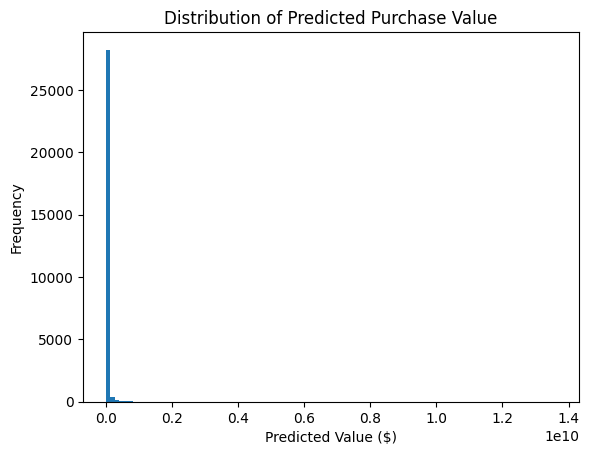

In [111]:

plt.hist(y_final_test_preds, bins=100)
plt.title(f"Distribution of Predicted Purchase Value")
plt.xlabel("Predicted Value ($)")
plt.ylabel("Frequency")
plt.show()

In [112]:

# Final submission 
submission = pd.DataFrame({
    'id': range(test_df.shape[0]),
    'purchaseValue': y_final_test_preds  
})
submission.to_csv("submission.csv", index=False)
print("submission.csv has been saved.")


submission.csv has been saved.
